# LN - Analysis - Decision impact

## Import Libraries setup parameters and compute resources

In [371]:
# Import libraries
import boto3
from botocore import UNSIGNED
from botocore.client import Config
from botocore.handlers import disable_signing
import numpy as np
import pandas as pd
import networkx as nx
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle
import re
import io
import math
import copy
import sklearn
from tqdm.notebook import trange, tqdm
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import math
from scipy.misc import factorial



ImportError: cannot import name 'factorial' from 'scipy.misc' (/opt/conda/lib/python3.7/site-packages/scipy/misc/__init__.py)

## Load Data

In [203]:
# Set s3 resource
s3 = boto3.resource('s3')
s3.meta.client.meta.events.register('choose-signer.s3.*',disable_signing)


# Set Bucket and extraction id for loading data
bucket='ln-strategy-data'

pd.set_option('display.max_rows', 100)


In [208]:
# Import Data Frames
decisions_load = s3.Object(bucket_name=bucket, key='full_decisions_df.csv').get()
full_decisions_df=pd.read_csv(io.BytesIO(decisions_load['Body'].read()))

In [246]:
full_decisions_df.head(20)

,Unnamed: 0,Unnamed: 0.1,short_channel_id,open_block,open_transaction,address,close_block,close_transaction,node0,node1,...,closeness_approx_rank_post_n0_close_norm_rankpost,closeness_approx_rank_post_n1_close_norm_rankpost,current_betweeness_unweighted_n0_open_norm_rank,current_betweeness_unweighted_n1_open_norm_rank,current_betweeness_unweighted_n0_close_norm_rank,current_betweeness_unweighted_n1_close_norm_rank,current_betweeness_unweighted_n0_open_norm_rankpost,current_betweeness_unweighted_n1_open_norm_rankpost,current_betweeness_unweighted_n0_close_norm_rankpost,current_betweeness_unweighted_n1_close_norm_rankpost
0,0,72475,617297x720x0,617297,5aa10236396e6f1118806e0725572e3681f750a39401d1...,bc1qxklh2cq63d4s9pn0lmv9n04k9ly7ndhny4d848d950...,NaN,NaN,029bf3edd752470fb554330e8d40f7f10d73e9f9838898...,02da8d5a759ee9e4438da617cfdb61c87f723fb76c4b63...,...,NaN,NaN,0.084238,0.026873,NaN,NaN,0.083861,0.014369,NaN,NaN
1,1,72473,617295x550x0,617295,3a52a4d6dc06418c9477d34c4ee834b46c6bd6e0a55b12...,bc1qc46akgl8s3le5g038n92ha90rm666u397gs6s5tmzh...,NaN,NaN,0237fefbe8626bf888de0cad8c73630e32746a22a2c4fa...,033edf115cbd38a6803d2912904c33d45df0d3c74a35dd...,...,NaN,NaN,0.060406,0.001278,NaN,NaN,0.018191,0.000531,NaN,NaN
2,2,72474,617295x1743x1,617295,0290e91d1007d8fb42c6a30c04af298337ea5e7833bc9e...,bc1qmadhqrsk77pgtpgt4k34hnjaysk290vfgsw2hua7p7...,NaN,NaN,028737303e12cb84643d1f0181812b559a56ef5d78b4c4...,03a503d8e30f2ff407096d235b5db63b4fcf3f89a653ac...,...,NaN,NaN,0.009378,0.115924,NaN,NaN,0.041591,0.171147,NaN,NaN
3,3,72472,617294x894x0,617294,801ef73a0e237275b81a625362b3173bcbea7aac0af280...,bc1q46yvjxf0dth8qwnlhzs00kczztgf38eh74eh6x5uec...,NaN,NaN,031567fdf33cb9b4ab081019199295ffce38218751842a...,033edf115cbd38a6803d2912904c33d45df0d3c74a35dd...,...,NaN,NaN,0.008583,0.000542,NaN,NaN,0.007532,0.001278,NaN,NaN
4,4,72470,617292x63x0,617292,557aaea396b8967031803fa8119fef9a17611229b7aea1...,bc1qw9vetekdv2kaw0gh4w5m60xdrwz968k7pwvw4fuzxy...,NaN,NaN,033edf115cbd38a6803d2912904c33d45df0d3c74a35dd...,03d37fca0656558de4fd86bbe490a38d84a46228e7ec13...,...,NaN,NaN,0.000364,0.192472,NaN,NaN,0.000542,0.168542,NaN,NaN


In [5]:
# Create Graph keys
extraction_id=1587447789
graph_keys = [obj.key 
        for obj in s3.Bucket(name=bucket).objects.all()
        if re.match(".*"+str(extraction_id)+"_connected/.*\.gpickle",obj.key)]

In [176]:
key='graph_snapshots/1587447789_connected/.data_transformations/avg_short_path/raw_score/508400.pkl'
int(key.split("/")[-1].split(".")[0]) 

508400

In [256]:
# Creat blocks array
open_blocks_set=set(full_decisions_df['open_block'])
close_blocks_set=set(full_decisions_df['open_block'])

blocks=sorted(list(open_blocks_set.union(close_blocks_set)))
blocks[:10]

[505149,
 506402,
 506847,
 508075,
 508090,
 508320,
 508400,
 508447,
 508503,
 508666]

In [200]:
"""
Function
--------
extract_snapshot_data
    Function that extracts overall graph metric for a collection of snapshots in S3 and outputs DataFrame

Parameters
----------
conn: S3 connection object object
    S3 connection object for the boto3 api
    
bucket: str
    S3 bucket where data is stored

extraction_id: int
    Id for data extraction 
    
measurement: str
    Name of measurement stored in S3
    
   
Returns
-------
data_df: DataFrame
    Pandas DataFrame with data values for each block (snapshot)

 
"""

def extract_snapshot_data(conn,bucket,extraction_id,measurement):
    
   
    # Initiate list to poputlate with values
    rows=[]
    
    # Load keys
    key_prefix='graph_snapshots/'+str(extraction_id)+'_connected/.data_transformations/'+measurement+'/raw_score/'
    #keys=[obj.key 
     #       for obj in s3.Bucket(name=bucket,Prefix=key_prefix).objects.all()
      #      if re.match(".*"+str(extraction_id)+'_connected/\.data_transformations/'+measurement+'/raw_score/.*\.pkl',obj.key)]
    
    keys=[obj.key for obj in s3.Bucket(name=bucket).objects.filter(Prefix=key_prefix)]
    
    
    #bucket_obj = conn.get_bucket(bucket, validate=False)
    #bucket.list(prefix=key_prefix)

    # Loop over keys and extract values
    for key in keys:
    
        # Exctract block from key value
        block=int(key.split("/")[-1].split(".")[0]) 

        # Retrieve data from S3
        response = s3.Object(bucket_name=bucket, key=key).get()
        value=pickle.loads(response['Body'].read())
        
        # Append to row list
        rows.append([block,value])
    
    # Convert rows to array and create DataFrame
    rows_array=np.array(rows)
    data_df=pd.DataFrame(rows_array, columns = ['block', measurement]) 
    
    
    return data_df

In [201]:
# Extract shortest path data
shortest_path_df=extract_snapshot_data(s3,bucket,extraction_id,'avg_short_path')

In [202]:
shortest_path_df.head()

,block,avg_short_path
0,508400.0,1.333333
1,509496.0,1.992095
2,511852.0,2.446970
3,513758.0,2.491979
4,514060.0,2.584874


In [211]:
# Extract robustness data
robustness_df=extract_snapshot_data(s3,bucket,extraction_id,'robustness_eff_loss_1.0')

In [212]:
robustness_df.head()

,block,robustness_eff_loss_1.0
0,509496.0,0.008624
1,511852.0,0.054267
2,513758.0,0.056636
3,514060.0,0.062203
4,514345.0,0.062203


In [225]:
# Join Dataframes
snapshot_mes_df=pd.merge(shortest_path_df,robustness_df,how='outer',left_on=['block'],right_on=['block'])


In [226]:
# Create efficiency column
snapshot_mes_df['efficiency']=1/snapshot_mes_df['avg_short_path']
# Drop nan
snapshot_mes_df=snapshot_mes_df.dropna()

In [227]:
snapshot_mes_df.head()

,block,avg_short_path,robustness_eff_loss_1.0,efficiency
1,509496.0,1.992095,0.008624,0.501984
2,511852.0,2.446970,0.054267,0.408669
3,513758.0,2.491979,0.056636,0.401288
4,514060.0,2.584874,0.062203,0.386866
5,514345.0,2.584874,0.062203,0.386866


### Data description

In [209]:
full_decisions_df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'short_channel_id', 'open_block',
       'open_transaction', 'address', 'close_block', 'close_transaction',
       'node0', 'node1', 'satoshis', 'last_seen', 'open_time', 'open_fee',
       'close_time', 'close_fee', 'last_update', 'close_type',
       'close_htlc_count', 'close_balance_a', 'close_balance_b', 'dec_id',
       'node0_id', 'node1_id', 'node_pair', 'age_n0_open_norm_rank',
       'age_n1_open_norm_rank', 'age_n0_close_norm_rank',
       'age_n1_close_norm_rank', 'capacity_n0_open_norm_rank',
       'capacity_n1_open_norm_rank', 'capacity_n0_close_norm_rank',
       'capacity_n1_close_norm_rank', 'capacity_growth_n0_open_norm_rank',
       'capacity_growth_n1_open_norm_rank',
       'capacity_growth_n0_close_norm_rank',
       'capacity_growth_n1_close_norm_rank', 'channels_n0_open_norm_rank',
       'channels_n1_open_norm_rank', 'closeness_approx_rank_n0_open_norm_rank',
       'closeness_approx_rank_n1_open_norm_rank',
       'closene

In [210]:
full_decisions_df.isnull().sum()

Unnamed: 0                                                  0
Unnamed: 0.1                                                0
short_channel_id                                            0
open_block                                                  0
open_transaction                                            0
address                                                     0
close_block                                             34121
close_transaction                                       34121
node0                                                       0
node1                                                       0
satoshis                                                    0
last_seen                                                   0
open_time                                                   0
open_fee                                                    0
close_time                                              34121
close_fee                                               34121
last_upd

### Data Transformations

### Node Distributions

In [313]:
# SCRIPT to create dataframe with feature values per node

features=['age','capacity_n','capacity_growth','channels','closeness','current_betweeness']
df_columns=list(full_decisions_df.columns)

# Create dictionary to store columns

df_dic={}

# Loop over features and Create DataFrame for each feature

for feature in features:

    # Extract columns that match feature reg_exp with block and node id
    feature_cols=[col for col in df_columns if (col.startswith(feature) and ('post' not in col))]
    array_list=[]
    
    for feature_col in feature_cols:
        
        
        if 'n0' in feature_col: # For node0 columns
        
            if 'open' in feature_col: # At open
                
                # Select block, node_id and feature col
                array_i=full_decisions_df[['open_block','node0_id',feature_col]].to_numpy()
                # Create array with 1s to represent that these are node status at open
                open_col=np.expand_dims(np.ones(len(array_i)), axis=1)
                # Add column with 1s
                array_i=np.concatenate((array_i,open_col),axis=1)
            
            elif 'close' in feature_col:
                
                # Select block, node_id and feature col
                array_i=full_decisions_df[['close_block','node0_id',feature_col]].to_numpy()
                # Create array with 1s to represent that these are node status at close
                close_col=np.expand_dims(np.zeros(len(array_i)), axis=1)
                # Add column with 1s
                array_i=np.concatenate((array_i,close_col),axis=1)
        
        elif 'n1' in feature_col: # For node1 columns
        
            if 'open' in feature_col: # At close
                
                # Select block, node_id and feature col
                array_i=full_decisions_df[['open_block','node1_id',feature_col]].to_numpy()
                # Create array with 1s to represent that these are node status at open
                open_col=np.expand_dims(np.ones(len(array_i)), axis=1)
                # Add column with 1s
                array_i=np.concatenate((array_i,open_col),axis=1)
            
            elif 'close' in feature_col:
                
                # Select block, node_id and feature col
                array_i=full_decisions_df[['close_block','node1_id',feature_col]].to_numpy()
                # Create array with 1s to represent that these are node status at close
                close_col=np.expand_dims(np.zeros(len(array_i)), axis=1)
                # Add column with 1s
                array_i=np.concatenate((array_i,close_col),axis=1)
                
            
        # Concatenate results vertically
        array_list.append(array_i)
        feature_rows=np.concatenate(array_list,axis=0)
        
    # Create DataFrame for feature
    df_dic[feature]=pd.DataFrame(feature_rows, columns = ['block', 'node',feature,'decision_type']) 
    
    
# Join Dictionaries into one

# Initate node dictionary
node_dic=list(df_dic.items())
df_list=[t[1] for t in node_dic]

node_feature_df_raw=pd.concat(df_list,axis=1)
node_feature_df=node_feature_df_raw.groupby(level=0, axis=1,).mean()
node_feature_df=node_feature_df.dropna()
node_feature_df.head()
    


,age,block,capacity_growth,capacity_n,channels,closeness,current_betweeness,decision_type,node
0,0.036720,617297.0,0.661339,0.106011,0.172872,0.983718,0.084238,1.0,5161.0
10,0.003344,617290.0,0.000448,0.000059,0.007092,0.705347,0.002170,1.0,994.0
11,0.000009,617289.0,0.000234,0.000031,0.001773,0.241699,0.000222,1.0,1260.0
12,0.380795,617289.0,0.000920,0.005139,0.014184,0.894494,0.003224,1.0,842.0
13,0.000232,617288.0,0.000123,0.000016,0.000887,0.583382,0.000000,1.0,2246.0


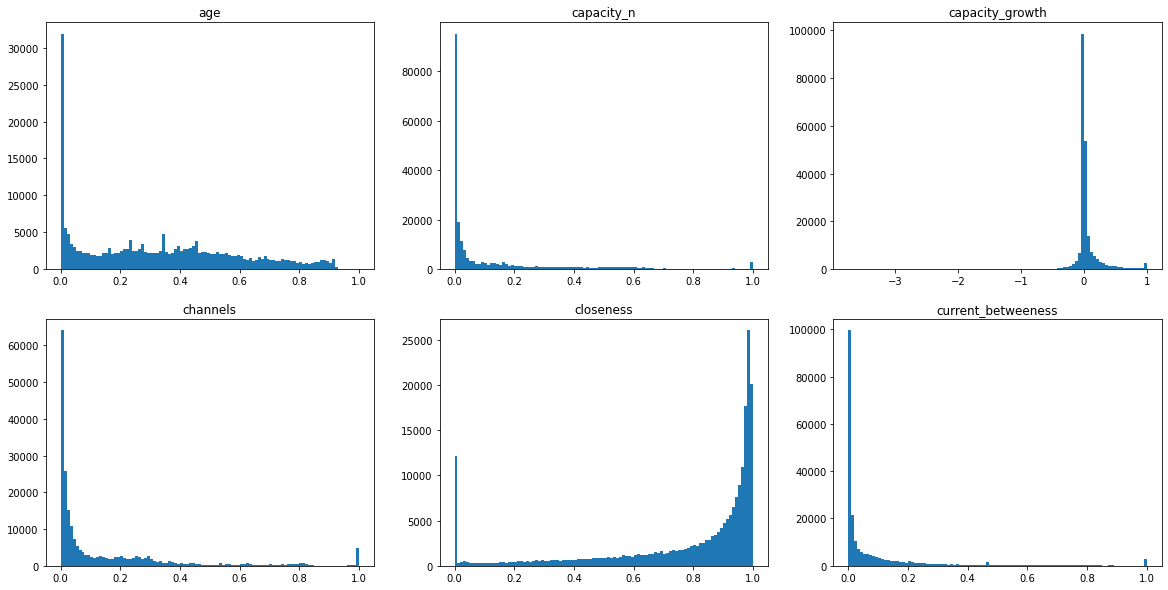

In [102]:
# Plot distributions
plt.figure(figsize=(20,10))
for i in range(6):
    plt.subplot(2,3, i+1)
    plt.hist(node_feature_df[features[i]], bins = 100)
    plt.title(features[i]);

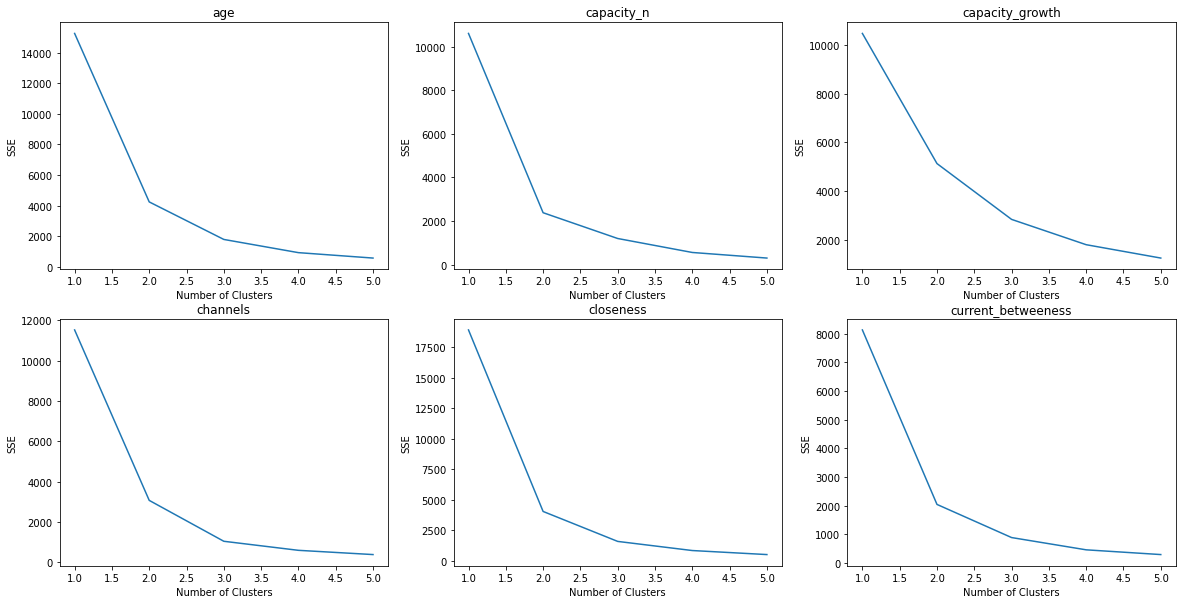

In [110]:
# Test clustering for features, to create small, medium and high categories

plt.figure(figsize=(20,10))
for i in range(len(features)):
    plt.subplot(2,3, i+1)
  

    # Cluster on avg_diff_df
    avg_diff_train = node_feature_df[features[i]].to_numpy()
    avg_diff_train=avg_diff_train.reshape(-1, 1)
    #avg_diff_test = avg_diff_df.iloc[test_idx]

    from sklearn.cluster import KMeans

    n_clusters = np.arange(1, 6)
    sse = []
    for n in n_clusters:
        kmeans = KMeans(n_clusters=n)
        kmeans.fit(avg_diff_train)
        sse.append(kmeans.inertia_)

    plt.plot(n_clusters, sse)
    plt.xlabel('Number of Clusters')
    plt.ylabel('SSE')
    plt.title(features[i])

### OPENS: Features

In [113]:
# Create simplified DataFrame with open decision data
open_columns = ['short_channel_id','open_block','node0_id', 'node1_id', 'satoshis', 'open_fee','age_n0_open_norm_rank',
       'age_n1_open_norm_rank', 'current_betweeness_unweighted_n0_open_norm_rank','current_betweeness_unweighted_n1_open_norm_rank',
       'capacity_n0_open_norm_rank', 'capacity_n1_open_norm_rank',
       'capacity_growth_n0_open_norm_rank',
       'capacity_growth_n1_open_norm_rank','channels_n0_open_norm_rank',
       'channels_n1_open_norm_rank', 'closeness_approx_rank_n0_open_norm_rank',
       'closeness_approx_rank_n1_open_norm_rank']
open_df = full_decisions_df.filter(open_columns)

In [9]:
open_df.head()

,short_channel_id,open_block,node0_id,node1_id,satoshis,open_fee,age_n0_open_norm_rank,age_n1_open_norm_rank,betweeness_curr_aprox_n0_open_norm_rank,betweeness_curr_aprox_n1_open_norm_rank,capacity_n0_open_norm_rank,capacity_n1_open_norm_rank,capacity_growth_n0_open_norm_rank,capacity_growth_n1_open_norm_rank,channels_n0_open_norm_rank,channels_n1_open_norm_rank,closeness_approx_rank_n0_open_norm_rank,closeness_approx_rank_n1_open_norm_rank
0,617297x720x0,617297,5161,7141,1000000,154,0.036720,0.662149,0.052707,0.022700,0.106011,0.005603,0.661339,-0.000250,0.172872,0.031028,0.983718,0.860247
1,617295x550x0,617295,135,7083,95675,4325,0.565990,0.000045,0.068319,0.000008,0.066994,0.000062,0.015602,0.000468,NaN,NaN,0.975678,0.454293
2,617295x1743x1,617295,7524,1232,500000,443,0.089714,0.685791,0.008368,0.048892,0.009225,0.107460,0.006130,0.056292,NaN,NaN,0.949207,0.991516
3,617294x894x0,617294,2205,7083,95675,4325,0.513273,0.000027,0.006075,0.000355,0.017337,0.000046,0.001786,0.000351,NaN,NaN,0.937162,0.470932
4,617292x63x0,617292,7083,6270,95675,4324,0.000018,0.598464,0.000008,0.202672,0.000031,0.387552,0.000234,-0.120011,NaN,NaN,0.376379,0.988756


In [10]:
# Missing values
open_df.isnull().sum()

short_channel_id                            0
open_block                                  0
node0_id                                    0
node1_id                                    0
satoshis                                    0
open_fee                                    0
age_n0_open_norm_rank                       7
age_n1_open_norm_rank                       7
betweeness_curr_aprox_n0_open_norm_rank     7
betweeness_curr_aprox_n1_open_norm_rank     7
capacity_n0_open_norm_rank                  7
capacity_n1_open_norm_rank                  7
capacity_growth_n0_open_norm_rank           7
capacity_growth_n1_open_norm_rank           7
channels_n0_open_norm_rank                 22
channels_n1_open_norm_rank                 22
closeness_approx_rank_n0_open_norm_rank     7
closeness_approx_rank_n1_open_norm_rank     7
dtype: int64

In [11]:
len(open_df)

72476

In [114]:
open_df.dropna(inplace = True)
len(open_df)

72454

In [245]:
X = open_df.drop(labels =['short_channel_id','open_block','node0_id', 'satoshis', 'node1_id', 'open_fee'], axis =1)

In [244]:
X.head()

,open_block,age_n0_open_norm_rank,age_n1_open_norm_rank,current_betweeness_unweighted_n0_open_norm_rank,current_betweeness_unweighted_n1_open_norm_rank,capacity_n0_open_norm_rank,capacity_n1_open_norm_rank,capacity_growth_n0_open_norm_rank,capacity_growth_n1_open_norm_rank,channels_n0_open_norm_rank,channels_n1_open_norm_rank,closeness_approx_rank_n0_open_norm_rank,closeness_approx_rank_n1_open_norm_rank
0,617297,0.036720,0.662149,0.084238,0.026873,0.106011,0.005603,0.661339,-0.000250,0.172872,0.031028,0.983718,0.860247
10,617290,0.003344,0.573025,0.002170,0.201943,0.000059,0.059653,0.000448,0.003720,0.007092,0.227837,0.705347,0.966929
11,617289,0.000009,0.754706,0.000222,0.031487,0.000031,0.085135,0.000234,-0.006180,0.001773,0.129433,0.241699,0.974934
12,617289,0.380795,0.000000,0.003224,0.000000,0.005139,0.000000,0.000920,0.000000,0.014184,0.000000,0.894494,0.000000
13,617288,0.000232,0.896458,0.000000,1.000000,0.000016,1.000000,0.000123,0.224461,0.000887,0.735816,0.583382,0.996093


In [119]:
corr = X.corr()
corr

,age_n0_open_norm_rank,age_n1_open_norm_rank,current_betweeness_unweighted_n0_open_norm_rank,current_betweeness_unweighted_n1_open_norm_rank,capacity_n0_open_norm_rank,capacity_n1_open_norm_rank,capacity_growth_n0_open_norm_rank,capacity_growth_n1_open_norm_rank,channels_n0_open_norm_rank,channels_n1_open_norm_rank,closeness_approx_rank_n0_open_norm_rank,closeness_approx_rank_n1_open_norm_rank
age_n0_open_norm_rank,1.000000,-0.180539,0.404021,-0.181278,0.281454,-0.175576,-0.035631,-0.082403,0.463904,-0.205130,0.540057,-0.203395
age_n1_open_norm_rank,-0.180539,1.000000,-0.199075,0.403102,-0.157111,0.334275,-0.058224,0.024129,-0.212689,0.482077,-0.180334,0.558591
current_betweeness_unweighted_n0_open_norm_rank,0.404021,-0.199075,1.000000,-0.177300,0.451186,-0.202776,0.187912,-0.098369,0.902954,-0.221379,0.366936,-0.245315
current_betweeness_unweighted_n1_open_norm_rank,-0.181278,0.403102,-0.177300,1.000000,-0.169151,0.562120,-0.079728,0.263559,-0.213284,0.889297,-0.231272,0.374636
capacity_n0_open_norm_rank,0.281454,-0.157111,0.451186,-0.169151,1.000000,-0.142974,0.494435,-0.053833,0.530494,-0.204895,0.411392,-0.163335
capacity_n1_open_norm_rank,-0.175576,0.334275,-0.202776,0.562120,-0.142974,1.000000,-0.049898,0.497533,-0.235213,0.656803,-0.185880,0.448278
capacity_growth_n0_open_norm_rank,-0.035631,-0.058224,0.187912,-0.079728,0.494435,-0.049898,1.000000,0.009727,0.200291,-0.091662,0.216460,-0.042520
capacity_growth_n1_open_norm_rank,-0.082403,0.024129,-0.098369,0.263559,-0.053833,0.497533,0.009727,1.000000,-0.112278,0.276748,-0.079329,0.223275
channels_n0_open_norm_rank,0.463904,-0.212689,0.902954,-0.213284,0.530494,-0.235213,0.200291,-0.112278,1.000000,-0.260825,0.450952,-0.256823
channels_n1_open_norm_rank,-0.205130,0.482077,-0.221379,0.889297,-0.204895,0.656803,-0.091662,0.276748,-0.260825,1.000000,-0.247344,0.478169


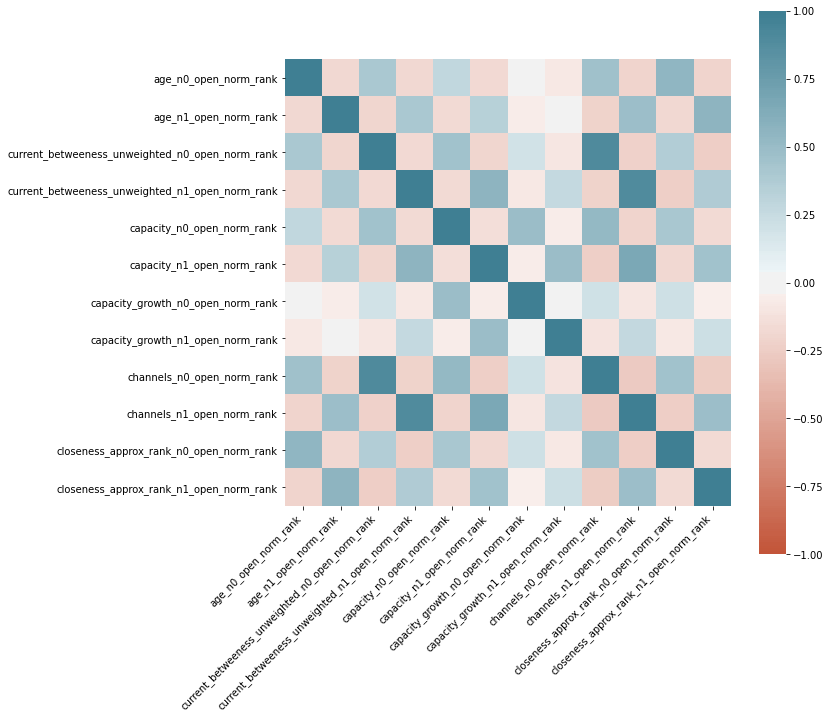

In [120]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [121]:
X['age_diff_open'] = np.abs(X['age_n0_open_norm_rank'] - X['age_n1_open_norm_rank'])
X['channel_diff_open'] = np.abs(X['channels_n0_open_norm_rank'] - X['channels_n1_open_norm_rank'])
#X['bet_diff_open'] = np.abs(X['betweeness_curr_aprox_n0_open_norm_rank'] - X['betweeness_curr_aprox_n1_open_norm_rank'])
#X['closeness_diff_open'] = np.abs(X['closeness_approx_rank_n0_open_norm_rank'] - X['closeness_approx_rank_n1_open_norm_rank'])
X['capacity_diff_open'] = np.abs(X['capacity_n0_open_norm_rank'] - X['capacity_n1_open_norm_rank'])
X['growth_diff_open'] = np.abs(X['capacity_growth_n0_open_norm_rank'] - X['capacity_growth_n1_open_norm_rank'])

In [122]:
X['age_avg_open'] = np.mean(X[['age_n0_open_norm_rank','age_n1_open_norm_rank']],axis =1)
X['channel_avg_open'] = np.mean(X[['channels_n0_open_norm_rank','channels_n1_open_norm_rank']],axis=1)
#X['bet_avg_open'] = np.mean(X[['betweeness_curr_aprox_n0_open_norm_rank','betweeness_curr_aprox_n1_open_norm_rank']], axis=1)
#X['closeness_avg_open'] = np.mean(X[['closeness_approx_rank_n0_open_norm_rank','closeness_approx_rank_n1_open_norm_rank']], axis=1)
X['capacity_avg_open'] = np.mean(X[['capacity_n0_open_norm_rank','capacity_n1_open_norm_rank']], axis=1)
X['growth_avg_open'] = np.mean(X[['capacity_growth_n0_open_norm_rank','capacity_growth_n1_open_norm_rank']], axis=1)

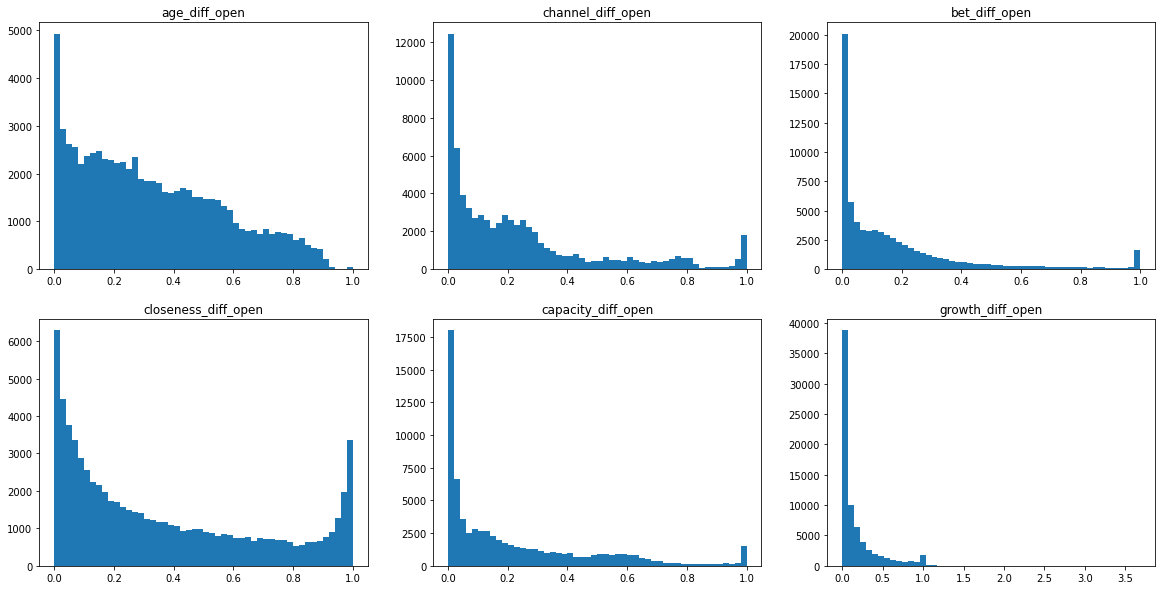

In [22]:
diffs = ['age_diff_open','channel_diff_open','bet_diff_open', 'closeness_diff_open', 'capacity_diff_open', 'growth_diff_open']
plt.figure(figsize=(20,10))
for i in range(6):
    plt.subplot(2,3, i+1)
    plt.hist(X[diffs[i]], bins = 50)
    plt.title(diffs[i]);

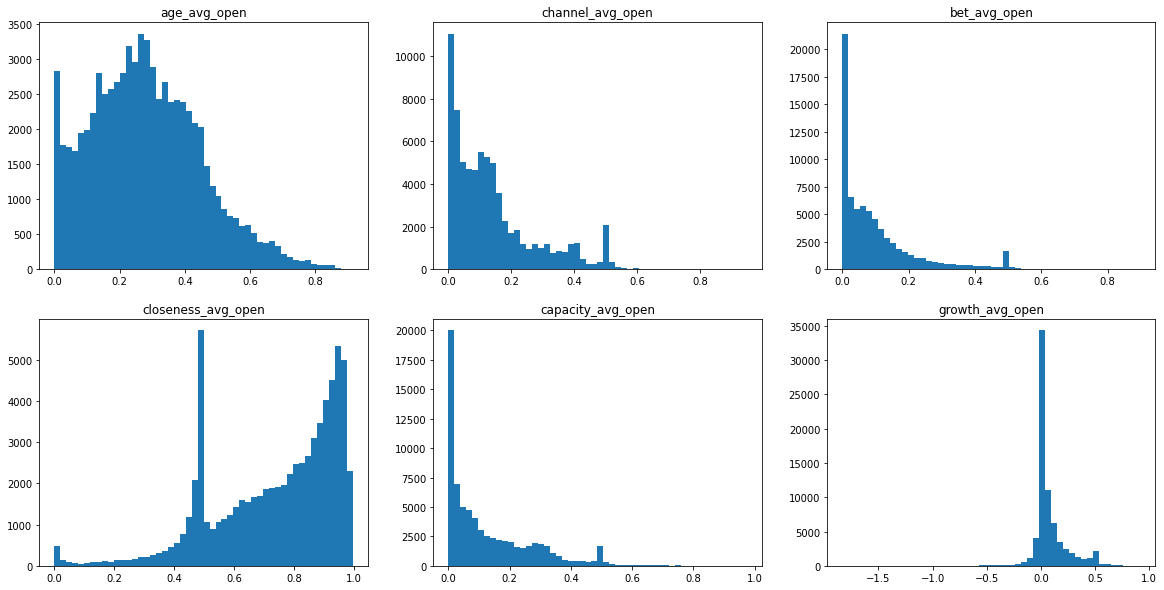

In [23]:
avgs = ['age_avg_open','channel_avg_open','bet_avg_open', 'closeness_avg_open', 'capacity_avg_open', 'growth_avg_open']
plt.figure(figsize=(20,10))
for i in range(6):
    plt.subplot(2,3, i+1)
    plt.hist(X[avgs[i]], bins = 50)
    plt.title(avgs[i]);

In [83]:
diff_df = X.filter(diffs)

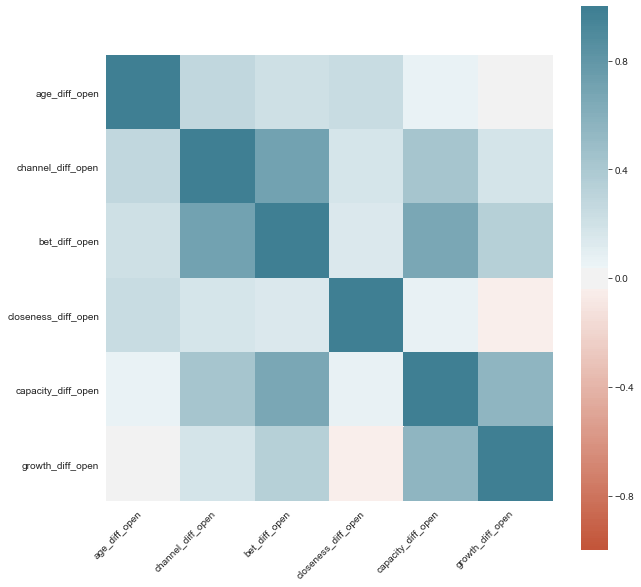

In [84]:
diff_corr = diff_df.corr()
plt.figure(figsize=(10,10))
ax = sns.heatmap(
    diff_corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [123]:
avg_diff_columns = ['age_avg_open','channel_avg_open', 
                   'capacity_avg_open', 'growth_avg_open', 'age_diff_open','channel_diff_open',
                    'capacity_diff_open', 'growth_diff_open']

avg_diff_df = X.filter(avg_diff_columns)

In [124]:
avg_diff_df.head()

,age_avg_open,channel_avg_open,capacity_avg_open,growth_avg_open,age_diff_open,channel_diff_open,capacity_diff_open,growth_diff_open
0,0.349434,0.101950,0.055807,0.330545,0.625429,0.141844,0.100407,0.661589
10,0.288184,0.117465,0.029856,0.002084,0.569681,0.220745,0.059594,0.003272
11,0.377358,0.065603,0.042583,-0.002973,0.754697,0.127660,0.085104,0.006414
12,0.190398,0.007092,0.002569,0.000460,0.380795,0.014184,0.005139,0.000920
13,0.448345,0.368351,0.500008,0.112292,0.896226,0.734929,0.999984,0.224337


In [9]:
# Train/Test Split

train_idx = np.random.choice(range(len(X)), int(len(X) * .8), replace=False)
test_idx = list(set(range(len(X))) - set(list(train_idx))) 
X_train = X.iloc[train_idx]
X_test = X.iloc[test_idx] # What is iloc again? how is it different from without it?
# Cluster on avg_diff_df
avg_diff_train = avg_diff_df.iloc[train_idx]
avg_diff_test = avg_diff_df.iloc[test_idx]

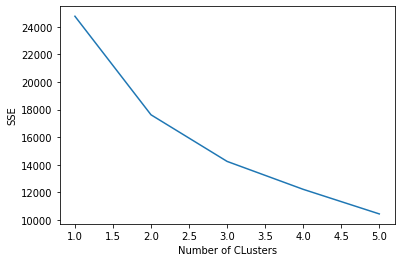

In [129]:
# Train on whole data set
avg_diff_train=avg_diff_df

from sklearn.cluster import KMeans

n_clusters = np.arange(1, 6)
sse = []
for n in n_clusters:
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(avg_diff_train)
    sse.append(kmeans.inertia_)

plt.plot(n_clusters, sse)
plt.xlabel('Number of CLusters')
plt.ylabel('SSE');

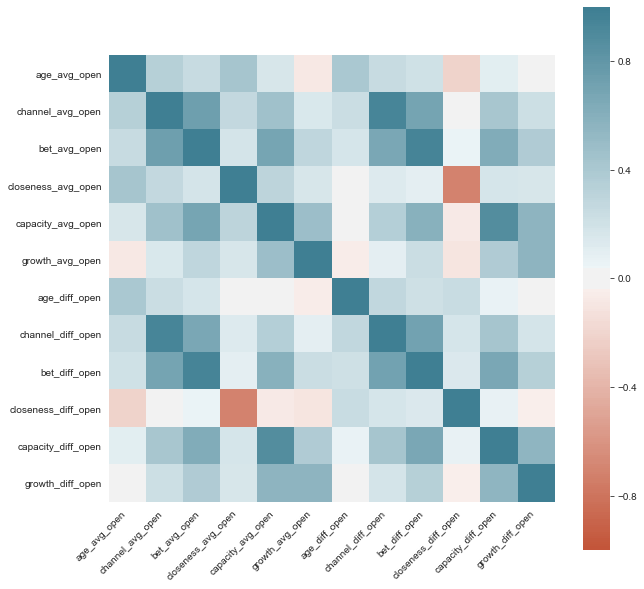

In [260]:
avg_diff_corr = avg_diff_df.corr()
plt.figure(figsize=(10,10))
ax = sns.heatmap(
    avg_diff_corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [268]:
avg_diff_corr

,age_avg_open,channel_avg_open,bet_avg_open,closeness_avg_open,capacity_avg_open,growth_avg_open,age_diff_open,channel_diff_open,bet_diff_open,closeness_diff_open,capacity_diff_open,growth_diff_open
age_avg_open,1.000000,0.337927,0.254981,0.431266,0.170356,-0.081645,0.404480,0.256469,0.198754,-0.214943,0.102444,0.006686
channel_avg_open,0.337927,1.000000,0.729942,0.268449,0.463483,0.156214,0.235054,0.939175,0.693583,0.022158,0.423101,0.220672
bet_avg_open,0.254981,0.729942,1.000000,0.186778,0.680079,0.290416,0.176846,0.669030,0.952624,0.047968,0.639264,0.374544
closeness_avg_open,0.431266,0.268449,0.186778,1.000000,0.300033,0.171019,-0.019088,0.125825,0.097243,-0.712199,0.179087,0.171445
capacity_avg_open,0.170356,0.463483,0.680079,0.300033,1.000000,0.477751,0.007671,0.356852,0.589353,-0.074418,0.876907,0.559828
growth_avg_open,-0.081645,0.156214,0.290416,0.171019,0.477751,1.000000,-0.049444,0.086610,0.228533,-0.104574,0.368632,0.558196
age_diff_open,0.404480,0.235054,0.176846,-0.019088,0.007671,-0.049444,1.000000,0.282426,0.212852,0.247993,0.065885,-0.014138
channel_diff_open,0.256469,0.939175,0.669030,0.125825,0.356852,0.086610,0.282426,1.000000,0.714206,0.173454,0.432444,0.182351
bet_diff_open,0.198754,0.693583,0.952624,0.097243,0.589353,0.228533,0.212852,0.714206,1.000000,0.146665,0.665449,0.345125
closeness_diff_open,-0.214943,0.022158,0.047968,-0.712199,-0.074418,-0.104574,0.247993,0.173454,0.146665,1.000000,0.072043,-0.044829


### K-means Clustering

In [163]:
"""
Function
--------
fit_kmeans
    Function that performs kmeans fitting on a dataframe

Parameters
----------
n_clusters : int
    Number of cluster to fit
    
x: DataFrame
    Pandas DataFrame with data to fit
    
random_state: int
    sklearn kmeans parameter

   
Returns
-------
clusters_i: DataFrame
    A copy of x that includes an extra column with the cluster corresponding to each observation
centroids_i: DataFrame
    A Dataframe with the feature values for every cluster's centroid
 
"""


def fit_kmeans(n_clusters,x,random_state=123):
    
    # Fit k means to x
    kmeans = KMeans(n_clusters= n_clusters, random_state = random_state)
    kmeans.fit(x)
    y_kmeans = kmeans.predict(x)
    centroids  = kmeans.cluster_centers_

    #print(kmeans.inertia_)
    # Define clusters dataframe
    clusters_i = copy.deepcopy(x)
    clusters_i['cluster_label'] = y_kmeans


    # Define centroids DataFrame
    centroids_i=pd.DataFrame(centroids, columns = list(x.columns)) 
    centroidsi_count=clusters_i[['age_avg_open','cluster_label']].groupby(['cluster_label']).agg('count').rename(columns={'age_avg_open': 'count'})
    centroids_i=pd.concat([centroids_i,centroidsi_count],axis=1)

    return clusters_i,centroids_i

**SCRIPT: Run function**

In [168]:
# Run fitting funcition
clusters_centroids=[]

min_clusters=2
max_clusters=4

for i in range(min_clusters,max_clusters+1): 
    (clusters_i,centroids_i)=fit_kmeans(i,avg_diff_train,random_state=123)
    clusters_centroids.append((clusters_i,centroids_i))


**2 Clusters**

In [170]:
# Print centroid DF for k=2
clusters_centroids[0][1].head()

,age_avg_open,channel_avg_open,capacity_avg_open,growth_avg_open,age_diff_open,channel_diff_open,capacity_diff_open,growth_diff_open,count
0,0.259082,0.076362,0.060494,0.037784,0.296867,0.111542,0.087782,0.069139,46246
1,0.323022,0.257699,0.255949,0.148034,0.377298,0.461799,0.451634,0.348983,26208


**3 Clusters**

In [172]:
# Print centroid DF for k=3
clusters_centroids[1][1].head()

,age_avg_open,channel_avg_open,capacity_avg_open,growth_avg_open,age_diff_open,channel_diff_open,capacity_diff_open,growth_diff_open,count
0,0.262571,0.076197,0.071599,0.035581,0.294709,0.111085,0.109683,0.071548,47846
1,0.274141,0.186819,0.326975,0.275222,0.290206,0.303670,0.559932,0.602261,12407
2,0.367501,0.354506,0.166099,0.042062,0.484997,0.670901,0.303860,0.119263,12201


**4 Clusters**

In [173]:
# Print centroid DF for k=4
clusters_centroids[2][1].head()

,age_avg_open,channel_avg_open,capacity_avg_open,growth_avg_open,age_diff_open,channel_diff_open,capacity_diff_open,growth_diff_open,count
0,0.206065,0.072208,0.073954,0.043062,0.144040,0.100584,0.106592,0.077460,29551
1,0.350132,0.095094,0.081637,0.027684,0.529752,0.152464,0.139511,0.075780,20917
2,0.372646,0.385898,0.165866,0.045130,0.473443,0.731145,0.300922,0.117504,10101
3,0.274979,0.190150,0.331348,0.279570,0.294034,0.311760,0.571264,0.613255,11885


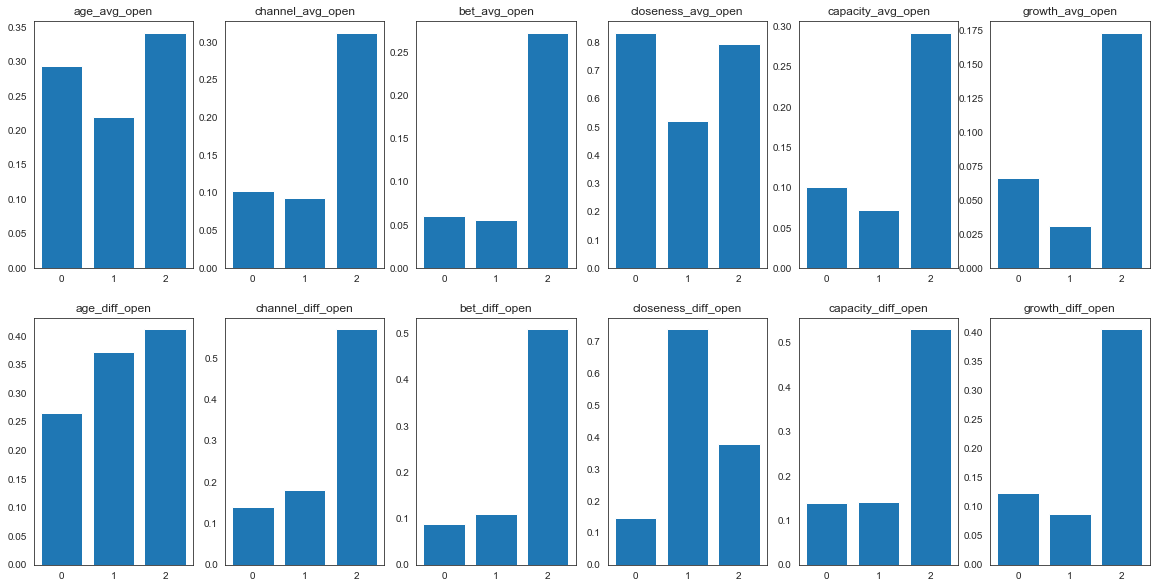

In [259]:
avg_diff_columns = avg_diff_df.columns
plt.figure(figsize=(20,10))
for i in range(len(avg_diff_columns)):
    plt.subplot(2,6, i+1)
    plt.bar(clusters3.groupby('cluster_label')[avg_diff_columns[i]].mean().index, clusters3.groupby('cluster_label')[avg_diff_columns[i]].mean());
    plt.title(avg_diff_columns[i]);

24812.29252437712


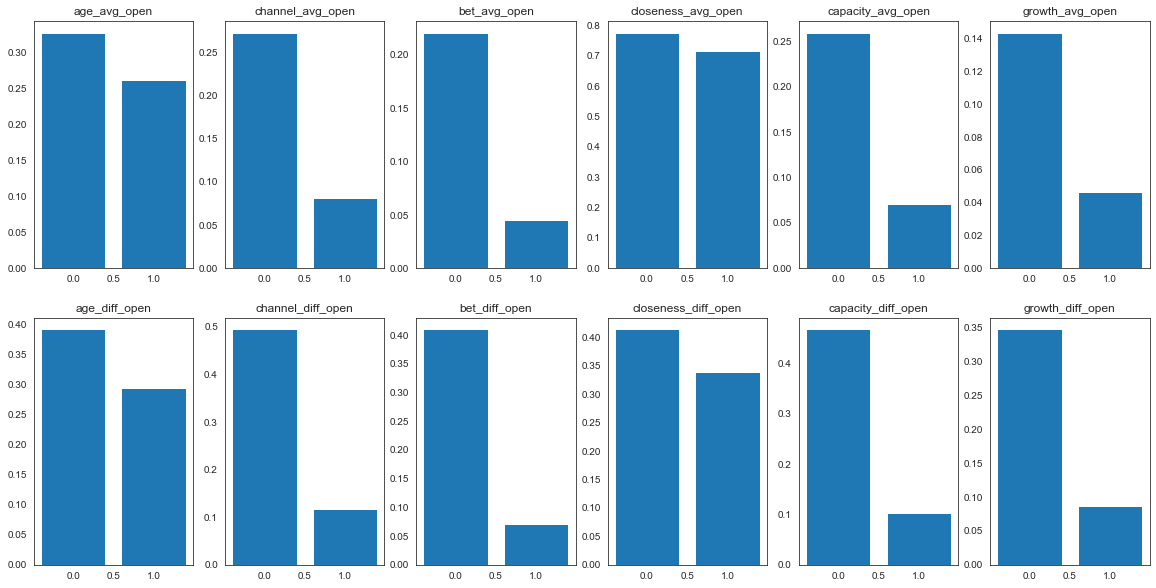

In [267]:
kmeans2 = KMeans(n_clusters= 2, random_state = 123)
kmeans2.fit(avg_diff_train)
y_kmeans2 = kmeans2.predict(avg_diff_train)
print(kmeans2.inertia_)
clusters2 = copy.deepcopy(avg_diff_train)
clusters2['cluster_label'] = y_kmeans2

plt.figure(figsize=(20,10))
for i in range(len(avg_diff_columns)):
    plt.subplot(2,6, i+1)
    plt.bar(clusters2.groupby('cluster_label')[avg_diff_columns[i]].mean().index, clusters2.groupby('cluster_label')[avg_diff_columns[i]].mean());
    plt.title(avg_diff_columns[i]);

In [265]:
kmeans4 = KMeans(n_clusters= 4, random_state = 123)
kmeans4.fit(avg_diff_train)
y_kmeans4 = kmeans4.predict(avg_diff_train)
print(kmeans4.inertia_)
clusters4 = copy.deepcopy(avg_diff_train)
clusters4['cluster_label'] = y_kmeans4

17625.662503645388


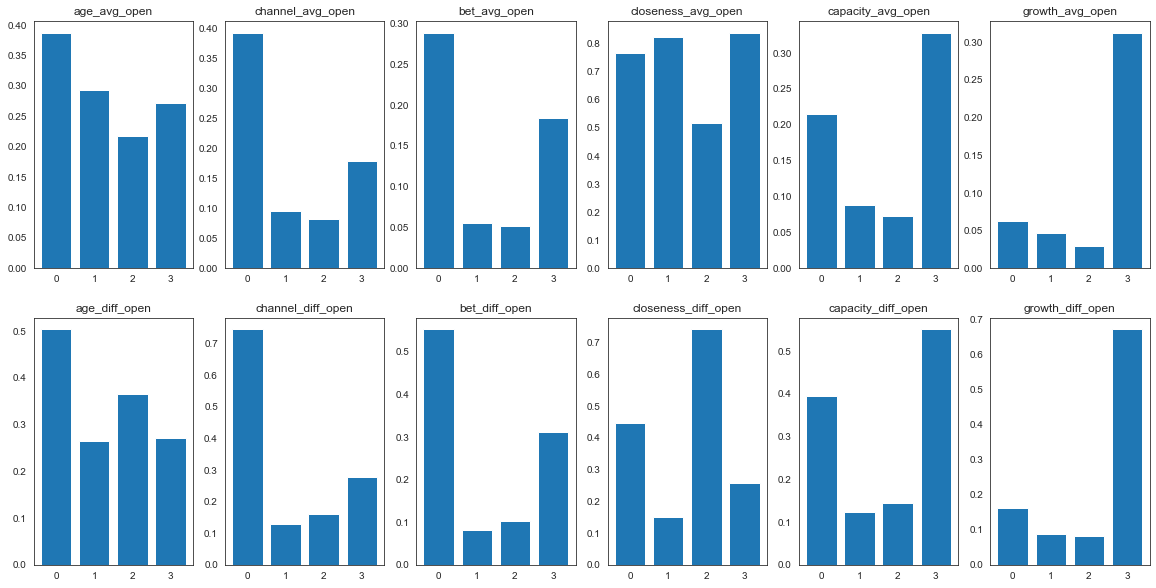

In [266]:
avg_diff_columns = avg_diff_df.columns
plt.figure(figsize=(20,10))
for i in range(len(avg_diff_columns)):
    plt.subplot(2,6, i+1)
    plt.bar(clusters4.groupby('cluster_label')[avg_diff_columns[i]].mean().index, clusters4.groupby('cluster_label')[avg_diff_columns[i]].mean());
    plt.title(avg_diff_columns[i]);

Text(0, 0.5, 'SSE')

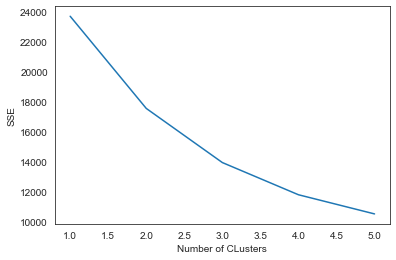

In [66]:
#Cluster only on diff columns

n_clusters = np.arange(1, 6)
sse_diff = []
for n in n_clusters:
    kmeans_diff = KMeans(n_clusters=n)
    kmeans_diff.fit(diff_train)
    sse_diff.append(kmeans_diff.inertia_)

plt.plot(n_clusters, sse_diff)
plt.xlabel('Number of CLusters')
plt.ylabel('SSE');

In [81]:
kmeans_diff = KMeans(n_clusters= 3, random_state = 456)
kmeans_diff.fit(diff_train)
y_kmeans_diff = kmeans_diff.predict(diff_train)
print(kmeans_diff.inertia_)
diff_clusters3 = copy.deepcopy(diff_train)
diff_clusters3['cluster_label'] = y_kmeans_diff
diff_clusters3.head(20)

13945.98467834022


,age_diff_open,channel_diff_open,bet_diff_open,closeness_diff_open,capacity_diff_open,growth_diff_open,cluster_label
38309,0.167601,0.323258,0.256711,0.646597,0.682121,0.619123,2
68455,0.539965,0.022599,0.004357,0.023928,0.001727,0.071528,0
26088,0.123678,0.534838,0.449665,0.048892,0.232558,0.024381,0
48520,0.663147,0.262530,0.390926,0.135122,0.991168,0.995463,2
48421,0.271539,0.235084,0.119944,0.468742,0.559856,0.277580,2
19697,0.507343,0.966436,0.830988,0.138472,0.176435,0.092566,2
37330,0.189879,0.132736,0.044857,0.840168,0.190944,0.281830,1
41566,0.115916,0.757812,0.754454,0.043884,0.669738,0.348123,2
24629,0.016757,0.094675,0.174249,0.043591,0.001253,0.004073,0
51753,0.186932,0.217784,0.106063,0.224129,0.398666,0.238102,0


(array([45716.,  8189.,  7763.,  3080.,  2107.,  1358.,  1199.,  1148.,
          782.,  1112.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

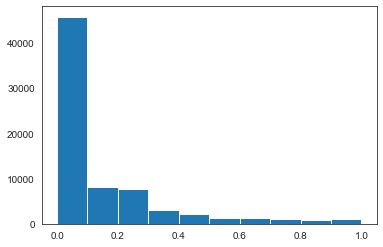

In [60]:
plt.hist(X['channels_n1_open_norm_rank']) # tag each node with label small, intermediate, big

(array([47493.,  7560.,  6849.,  2844.,  1244.,  1077.,  1162.,  1576.,
          750.,  1899.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

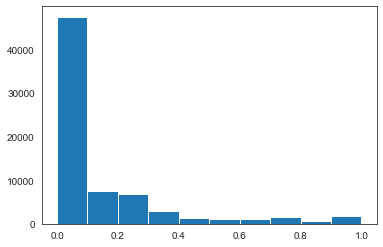

In [61]:
plt.hist(X['channels_n0_open_norm_rank'])

Text(0, 0.5, 'SSE')

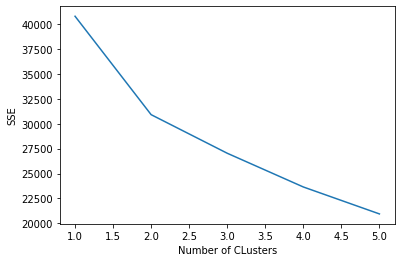

In [12]:
n_clusters = np.arange(1, 6)
sse = []
for n in n_clusters:
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(X_train)
    sse.append(kmeans.inertia_)

plt.plot(n_clusters, sse)
plt.xlabel('Number of CLusters')
plt.ylabel('SSE')

In [14]:
from sklearn import decomposition
from sklearn.decomposition import PCA

pca = decomposition.PCA(n_components = 3)
train_pca = pca.fit_transform(X_train)
print("The amount of variance explained by the projected data is {}%".format(np.sum(pca.explained_variance_ratio_)))
print("Dimension of original data {}".format(X_train.shape))
print("Dimension of projected data reprentation {}".format(train_pca.shape))

The amount of variance explained by the projected data is 0.6470429052883233%
Dimension of original data (57963, 12)
Dimension of projected data reprentation (57963, 3)


In [45]:
pca.components_

array([[-0.29340756,  0.31864694, -0.20856982,  0.26651066, -0.19945029,
         0.31612794, -0.08581338,  0.1606631 , -0.28985506,  0.29797445,
        -0.39656525,  0.44145696],
       [ 0.33371817,  0.25219054,  0.21332228,  0.20669727,  0.23880737,
         0.27414541,  0.13668311,  0.17408881,  0.26940883,  0.21145373,
         0.5281839 ,  0.39919429],
       [ 0.00975327,  0.4603444 , -0.07174877, -0.27804352, -0.05686137,
        -0.40507395, -0.04314198, -0.55988898, -0.04994674, -0.15272749,
         0.10392478,  0.43157395]])

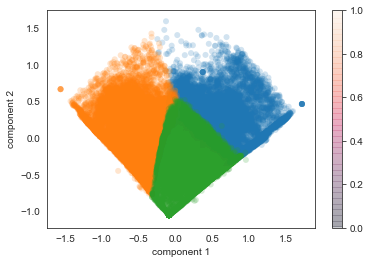

In [33]:
# Plot the clusters from the perspectives of the first two principal components in a 2d graph
for i in np.unique(kmeans.labels_):
    plt.scatter(train_pca[kmeans.labels_ == i, 0], train_pca[kmeans.labels_ == i, 1], edgecolor='none', alpha=0.2, 
                cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

<Figure size 480x480 with 0 Axes>

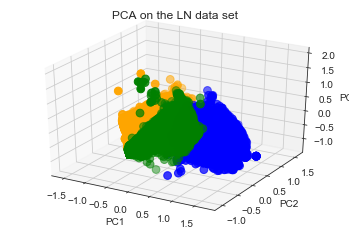

In [37]:
# Plot the clusters from the perspectives of the first three principal components in 3d graph
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_style("white")
my_dpi=96
plt.figure(figsize=(480/my_dpi, 480/my_dpi), dpi=my_dpi)

# Store results of PCA in a data frame
# result= pd.DataFrame(pca.transform(X_train), columns=['PCA%i' % i for i in range(3)], index=X_train.index)
 
# Plot initialisation
colors = ['blue','orange','green']
fig = plt.figure()
ax = fig.gca(projection='3d')
for i in np.unique(kmeans.labels_):
    ax.scatter(train_pca[kmeans.labels_ == i, 0], train_pca[kmeans.labels_ == i, 1], train_pca[kmeans.labels_ == i, 2],
               c=colors[i], cmap="Set2_r", s=60)
# ax.scatter(xs, ys, zs, c='r', marker='o')
# ax.scatter(xt, yt, zt, c='b', marker='^')
 
# make simple, bare axis lines through space:
# xAxisLine = ((min(result['PCA0']), max(result['PCA0'])), (0, 0), (0,0))
# ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
# yAxisLine = ((0, 0), (min(result['PCA1']), max(result['PCA1'])), (0,0))
# ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
# zAxisLine = ((0, 0), (0,0), (min(result['PCA2']), max(result['PCA2'])))
# ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')
 
# label the axes
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("PCA on the LN data set")
plt.show();


### Dataframe of Channels that are Closed

In [128]:
close_df = full_decisions_df[full_decisions_df['close_block'].notnull()]
print('How many closes: ',len(close_df))
close_df.head()

How many closes:  38355


,Unnamed: 0,Unnamed: 0.1,short_channel_id,open_block,open_transaction,address,close_block,close_transaction,node0,node1,...,capacity_growth_n0_close_norm_rank,capacity_growth_n1_close_norm_rank,channels_n0_open_norm_rank,channels_n1_open_norm_rank,closeness_approx_rank_n0_open_norm_rank,closeness_approx_rank_n1_open_norm_rank,closeness_approx_rank_n0_close_norm_rank,closeness_approx_rank_n1_close_norm_rank,channels_n0_close_norm_rank,channels_n1_close_norm_rank
278,278,72178,617118x511x1,617118,2a18821070d2e46d20e1d94b3dfa2dae894ec78755749f...,bc1q5czf4zz7ut8acvx8dm6q8ffse8yqq7tv86n09pt6xe...,617245.0,26faabb331ef297008d7684e09b8ba530be41457a9488b...,039edc94987c8f3adc28dab455efc00dea876089a120f5...,03b27c85b6359c5c688a900f6cc271cb47945d76e1c391...,...,0.073384,0.057292,0.250667,0.000889,0.990977,0.458562,0.982420,0.300888,0.251779,0.000890
347,347,72112,617078x1074x1,617078,aa58b7004d09169797cf1d22d777bf9c360038a5203de3...,bc1q2pjwaq6wzuwrdgsk2s2t27vn56xgx9neczukz2au5g...,617186.0,e2578e1c85904ca2324d238f1da0df3e700adfc5e1fb09...,0289d4c6dbf647db4c24decc6d2e50d5d1d0536fd15496...,02c12b5459cf107ee0440cae41902f1189db50fa003a07...,...,0.000658,0.114918,0.007993,0.087034,0.820601,0.971561,0.802935,0.977850,0.009795,0.087266
348,348,72111,617078x1073x0,617078,e8510183e69482b8787fbc8a9849b4799dbb77f1a735ec...,bc1qdmyfvtzlqnyjvczusx3tv9332t9rf5k6axl56yff65...,617186.0,c87ace7dde238ffb13158b37fa25ff5da7602268cd2f03...,0289d4c6dbf647db4c24decc6d2e50d5d1d0536fd15496...,030043d0a2cfb69d80867094eb030f8abde7a5dc36e1a0...,...,0.000658,-0.008398,0.007993,0.005329,0.820601,0.742814,0.802935,0.788087,0.009795,0.006233
349,349,72110,617078x1072x0,617078,81b09c2cd9596a61863533e7cdeac76141a63c445965e8...,bc1qn9e0tghjs7aj9mkferducy0zvezykmvu28pdp0glu6...,617186.0,a58998f8096668624e6c2317c4274f8f73916f6142d6d5...,0289d4c6dbf647db4c24decc6d2e50d5d1d0536fd15496...,03bb88ccc444534da7b5b64b4f7b15e1eccb18e102db0e...,...,0.000658,0.116228,0.007993,0.539964,0.820601,0.992634,0.802935,0.994270,0.009795,0.540516
350,350,72109,617078x1071x0,617078,a5e42f74802d63ba6d57ce0f7a5edeba76e5f21a990557...,bc1qg7pu3y76lducfxtpxtff84suwhk20v5luhxsed97m6...,617187.0,e555009d6b51e50318da6801d4e8788d4b956991a49659...,021802799027508e8a8bf9a0ab96ea78a6a995926a0b13...,0289d4c6dbf647db4c24decc6d2e50d5d1d0536fd15496...,...,0.000261,0.000431,0.042629,0.007993,0.902019,0.820601,0.901865,0.531963,0.043633,0.004452


In [129]:
close_columns = ['short_channel_id','open_block','close_block','node0_id', 'node1_id', 'satoshis', 'open_fee','age_n0_open_norm_rank',
       'age_n1_open_norm_rank', 'betweeness_curr_aprox_n0_open_norm_rank','betweeness_curr_aprox_n1_open_norm_rank',
       'capacity_n0_open_norm_rank', 'capacity_n1_open_norm_rank','capacity_growth_n0_open_norm_rank',
       'capacity_growth_n1_open_norm_rank','channels_n0_open_norm_rank','channels_n1_open_norm_rank', 
       'closeness_approx_rank_n0_open_norm_rank','closeness_approx_rank_n1_open_norm_rank', 'age_n0_close_norm_rank',
       'age_n1_close_norm_rank', 'betweeness_curr_aprox_n0_close_norm_rank','betweeness_curr_aprox_n1_close_norm_rank',
       'capacity_n0_close_norm_rank', 'capacity_n1_close_norm_rank','capacity_growth_n0_close_norm_rank',
       'capacity_growth_n1_close_norm_rank','channels_n0_close_norm_rank','channels_n1_close_norm_rank', 
       'closeness_approx_rank_n0_close_norm_rank','closeness_approx_rank_n1_close_norm_rank']
close_df = close_df.filter(close_columns)
close_df.head()

,short_channel_id,open_block,close_block,node0_id,node1_id,satoshis,open_fee,age_n0_open_norm_rank,age_n1_open_norm_rank,betweeness_curr_aprox_n0_open_norm_rank,...,betweeness_curr_aprox_n0_close_norm_rank,betweeness_curr_aprox_n1_close_norm_rank,capacity_n0_close_norm_rank,capacity_n1_close_norm_rank,capacity_growth_n0_close_norm_rank,capacity_growth_n1_close_norm_rank,channels_n0_close_norm_rank,channels_n1_close_norm_rank,closeness_approx_rank_n0_close_norm_rank,closeness_approx_rank_n1_close_norm_rank
278,617118x511x1,617118,617245.0,1392,5286,11000000,1694,0.596447,0.001331,0.449403,...,0.126052,1.867708e-12,0.364293,0.007223,0.073384,0.057292,0.251779,0.000890,0.982420,0.300888
347,617078x1074x1,617078,617186.0,994,6065,20000,4582,0.001447,0.548840,0.000076,...,0.000133,7.790642e-02,0.000081,0.179109,0.000658,0.114918,0.009795,0.087266,0.802935,0.977850
348,617078x1073x0,617078,617186.0,994,7088,20000,4582,0.001447,0.894806,0.000076,...,0.000133,1.257137e-03,0.000081,0.003813,0.000658,-0.008398,0.009795,0.006233,0.802935,0.788087
349,617078x1072x0,617078,617186.0,994,4249,20000,4582,0.001447,0.756815,0.000076,...,0.000133,2.132576e-01,0.000081,0.192646,0.000658,0.116228,0.009795,0.540516,0.802935,0.994270
350,617078x1071x0,617078,617187.0,5864,994,20000,4581,0.521233,0.001447,0.003057,...,0.003704,4.946882e-05,0.007071,0.000053,0.000261,0.000431,0.043633,0.004452,0.901865,0.531963


In [178]:
close_df['channel_age'] = close_df.close_block.astype('int') - close_df.open_block
close_df.head()

,short_channel_id,open_block,close_block,node0_id,node1_id,satoshis,open_fee,age_n0_open_norm_rank,age_n1_open_norm_rank,betweeness_curr_aprox_n0_open_norm_rank,...,betweeness_curr_aprox_n1_close_norm_rank,capacity_n0_close_norm_rank,capacity_n1_close_norm_rank,capacity_growth_n0_close_norm_rank,capacity_growth_n1_close_norm_rank,channels_n0_close_norm_rank,channels_n1_close_norm_rank,closeness_approx_rank_n0_close_norm_rank,closeness_approx_rank_n1_close_norm_rank,channel_age
278,617118x511x1,617118,617245.0,1392,5286,11000000,1694,0.596447,0.001331,0.449403,...,1.867708e-12,0.364293,0.007223,0.073384,0.057292,0.251779,0.000890,0.982420,0.300888,127
347,617078x1074x1,617078,617186.0,994,6065,20000,4582,0.001447,0.548840,0.000076,...,7.790642e-02,0.000081,0.179109,0.000658,0.114918,0.009795,0.087266,0.802935,0.977850,108
348,617078x1073x0,617078,617186.0,994,7088,20000,4582,0.001447,0.894806,0.000076,...,1.257137e-03,0.000081,0.003813,0.000658,-0.008398,0.009795,0.006233,0.802935,0.788087,108
349,617078x1072x0,617078,617186.0,994,4249,20000,4582,0.001447,0.756815,0.000076,...,2.132576e-01,0.000081,0.192646,0.000658,0.116228,0.009795,0.540516,0.802935,0.994270,108
350,617078x1071x0,617078,617187.0,5864,994,20000,4581,0.521233,0.001447,0.003057,...,4.946882e-05,0.007071,0.000053,0.000261,0.000431,0.043633,0.004452,0.901865,0.531963,109


In [180]:
close_df.dropna(inplace=True)

Text(0.5, 1.0, 'distribution of channel age')

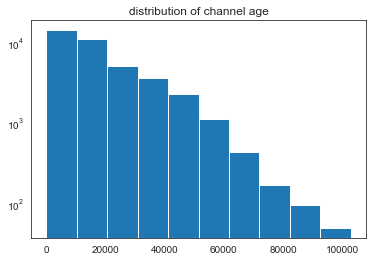

In [294]:
plt.hist(close_df.channel_age)
plt.yscale('log')
plt.title('distribution of channel age')

In [135]:
Xy_close = close_df.drop(labels =['short_channel_id','open_block','close_block','node0_id', 'node1_id', 'satoshis', 'open_fee'], axis =1)

Xy_close.corr()

,age_n0_open_norm_rank,age_n1_open_norm_rank,betweeness_curr_aprox_n0_open_norm_rank,betweeness_curr_aprox_n1_open_norm_rank,capacity_n0_open_norm_rank,capacity_n1_open_norm_rank,capacity_growth_n0_open_norm_rank,capacity_growth_n1_open_norm_rank,channels_n0_open_norm_rank,channels_n1_open_norm_rank,...,betweeness_curr_aprox_n1_close_norm_rank,capacity_n0_close_norm_rank,capacity_n1_close_norm_rank,capacity_growth_n0_close_norm_rank,capacity_growth_n1_close_norm_rank,channels_n0_close_norm_rank,channels_n1_close_norm_rank,closeness_approx_rank_n0_close_norm_rank,closeness_approx_rank_n1_close_norm_rank,channel_age
age_n0_open_norm_rank,1.000000,-0.209950,0.401833,-0.167916,0.277335,-0.147721,-0.019630,-0.062170,0.404584,-0.196229,...,-0.162728,0.231855,-0.141710,-0.010127,0.037650,0.317468,-0.187858,0.370289,-0.134974,-0.046359
age_n1_open_norm_rank,-0.209950,1.000000,-0.180816,0.404623,-0.148500,0.321524,-0.043540,0.030609,-0.217080,0.464913,...,0.389272,-0.144612,0.317517,0.037595,-0.005321,-0.214365,0.405000,-0.129273,0.414472,-0.074623
betweeness_curr_aprox_n0_open_norm_rank,0.401833,-0.180816,1.000000,-0.174077,0.714455,-0.194169,0.326117,-0.103520,0.732100,-0.210911,...,-0.175931,0.635880,-0.195056,-0.038283,0.024712,0.668606,-0.214496,0.340704,-0.120613,0.076142
betweeness_curr_aprox_n1_open_norm_rank,-0.167916,0.404623,-0.174077,1.000000,-0.180009,0.774693,-0.084323,0.397788,-0.219569,0.803043,...,0.772988,-0.176719,0.679672,0.029052,-0.064820,-0.223886,0.718326,-0.121080,0.351495,0.039914
capacity_n0_open_norm_rank,0.277335,-0.148500,0.714455,-0.180009,1.000000,-0.187067,0.516316,-0.096452,0.492303,-0.221086,...,-0.175258,0.894376,-0.187001,-0.064742,0.022005,0.459443,-0.219808,0.373834,-0.106225,-0.031726
capacity_n1_open_norm_rank,-0.147721,0.321524,-0.194169,0.774693,-0.187067,1.000000,-0.084387,0.543213,-0.245670,0.638874,...,0.712584,-0.185198,0.884256,0.031390,-0.083353,-0.247985,0.584289,-0.123420,0.407123,-0.056104
capacity_growth_n0_open_norm_rank,-0.019630,-0.043540,0.326117,-0.084323,0.516316,-0.084387,1.000000,-0.017067,0.200371,-0.106704,...,-0.077847,0.527656,-0.088395,0.112012,-0.040490,0.221495,-0.106858,0.220323,-0.003621,0.083840
capacity_growth_n1_open_norm_rank,-0.062170,0.030609,-0.103520,0.397788,-0.096452,0.543213,-0.017067,1.000000,-0.129811,0.291948,...,0.376350,-0.091072,0.514156,0.007303,0.067572,-0.133030,0.306207,-0.032095,0.233376,0.108878
channels_n0_open_norm_rank,0.404584,-0.217080,0.732100,-0.219569,0.492303,-0.245670,0.200371,-0.129811,1.000000,-0.257910,...,-0.221316,0.470871,-0.245707,-0.052740,0.036167,0.909806,-0.264368,0.406041,-0.140635,0.044962
channels_n1_open_norm_rank,-0.196229,0.464913,-0.210911,0.803043,-0.221086,0.638874,-0.106704,0.291948,-0.257910,1.000000,...,0.726062,-0.219274,0.586355,0.027636,-0.063937,-0.264286,0.905376,-0.135521,0.419896,0.035691


In [182]:
# split into train, test
close_X = close_df.drop(labels =['short_channel_id','open_block','close_block','node0_id', 'node1_id', 'satoshis', 'open_fee', 'channel_age'], axis =1)
close_y = close_df['channel_age']


In [156]:
close_X.columns

Index(['age_n0_open_norm_rank', 'age_n1_open_norm_rank',
       'betweeness_curr_aprox_n0_open_norm_rank',
       'betweeness_curr_aprox_n1_open_norm_rank', 'capacity_n0_open_norm_rank',
       'capacity_n1_open_norm_rank', 'capacity_growth_n0_open_norm_rank',
       'capacity_growth_n1_open_norm_rank', 'channels_n0_open_norm_rank',
       'channels_n1_open_norm_rank', 'closeness_approx_rank_n0_open_norm_rank',
       'closeness_approx_rank_n1_open_norm_rank', 'age_n0_close_norm_rank',
       'age_n1_close_norm_rank', 'betweeness_curr_aprox_n0_close_norm_rank',
       'betweeness_curr_aprox_n1_close_norm_rank',
       'capacity_n0_close_norm_rank', 'capacity_n1_close_norm_rank',
       'capacity_growth_n0_close_norm_rank',
       'capacity_growth_n1_close_norm_rank', 'channels_n0_close_norm_rank',
       'channels_n1_close_norm_rank',
       'closeness_approx_rank_n0_close_norm_rank',
       'closeness_approx_rank_n1_close_norm_rank'],
      dtype='object')

In [271]:
# close_X['age_diff_close'] = np.abs(close_X['age_n0_close_norm_rank'] - close_X['age_n1_close_norm_rank'])
close_X['channel_diff_close'] = np.abs(close_X['channels_n0_close_norm_rank'] - close_X['channels_n1_close_norm_rank'])
close_X['bet_diff_close'] = np.abs(close_X['betweeness_curr_aprox_n0_close_norm_rank'] - close_X['betweeness_curr_aprox_n1_close_norm_rank'])
close_X['closeness_diff_close'] = np.abs(close_X['closeness_approx_rank_n0_close_norm_rank'] - close_X['closeness_approx_rank_n1_close_norm_rank'])
close_X['capacity_diff_close'] = np.abs(close_X['capacity_n0_close_norm_rank'] - close_X['capacity_n1_close_norm_rank'])
close_X['growth_diff_close'] = np.abs(close_X['capacity_growth_n0_close_norm_rank'] - close_X['capacity_growth_n1_close_norm_rank'])

# close_X['age_avg_close'] = np.mean(close_X['age_n0_close_norm_rank'] + close_X['age_n1_close_norm_rank'])
close_X['channel_avg_close'] = np.mean(close_X[['channels_n0_close_norm_rank','channels_n1_close_norm_rank']], axis=1)
close_X['bet_avg_close'] = np.mean(close_X[['betweeness_curr_aprox_n0_close_norm_rank','betweeness_curr_aprox_n1_close_norm_rank']], axis=1)
close_X['closeness_avg_close'] = np.mean(close_X[['closeness_approx_rank_n0_close_norm_rank','closeness_approx_rank_n1_close_norm_rank']], axis=1)
close_X['capacity_avg_close'] = np.mean(close_X[['capacity_n0_close_norm_rank','capacity_n1_close_norm_rank']], axis=1)
close_X['growth_avg_close'] = np.mean(close_X[['capacity_growth_n0_close_norm_rank', 'capacity_growth_n1_close_norm_rank']], axis=1)

close_avg_diff_columns = ['channel_diff_close','bet_diff_close', 'closeness_diff_close', 
                      'capacity_diff_close', 'growth_diff_close', 'channel_avg_close',
                      'bet_avg_close', 'closeness_avg_close', 'capacity_avg_close', 'growth_avg_close']

In [274]:
close_avg_diff_X = close_X.filter(close_avg_diff_columns)

,channel_diff_close,bet_diff_close,closeness_diff_close,capacity_diff_close,growth_diff_close,channel_avg_close,bet_avg_close,closeness_avg_close,capacity_avg_close,growth_avg_close
278,0.250890,0.126052,0.681531,0.357069,0.016091,0.126335,0.063026,0.641654,0.185758,0.065338
347,0.077471,0.077773,0.174914,0.179028,0.114259,0.048531,0.039020,0.890393,0.089595,0.057788
348,0.003562,0.001124,0.014849,0.003732,0.009056,0.008014,0.000695,0.795511,0.001947,-0.003870
349,0.530721,0.213125,0.191335,0.192566,0.115570,0.275156,0.106695,0.898603,0.096364,0.058443
350,0.039181,0.003655,0.369903,0.007018,0.000170,0.024043,0.001877,0.716914,0.003562,0.000346


In [164]:
avg_diff_df.columns

Index(['age_avg_open', 'channel_avg_open', 'bet_avg_open',
       'closeness_avg_open', 'capacity_avg_open', 'growth_avg_open',
       'age_diff_open', 'channel_diff_open', 'bet_diff_open',
       'closeness_diff_open', 'capacity_diff_open', 'growth_diff_open'],
      dtype='object')

In [275]:
close_avg_diff_X = close_avg_diff_X.join(avg_diff_df).drop(labels =['age_avg_open','age_diff_open'], axis=1)
close_avg_diff_X.head()

,channel_diff_close,bet_diff_close,closeness_diff_close,capacity_diff_close,growth_diff_close,channel_avg_close,bet_avg_close,closeness_avg_close,capacity_avg_close,growth_avg_close,channel_avg_open,bet_avg_open,closeness_avg_open,capacity_avg_open,growth_avg_open,channel_diff_open,bet_diff_open,closeness_diff_open,capacity_diff_open,growth_diff_open
278,0.250890,0.126052,0.681531,0.357069,0.016091,0.126335,0.063026,0.641654,0.185758,0.065338,0.125778,0.224701,0.724769,0.182242,0.044092,0.249778,0.449403,0.532415,0.353668,0.004669
347,0.077471,0.077773,0.174914,0.179028,0.114259,0.048531,0.039020,0.890393,0.089595,0.057788,0.047513,0.032525,0.896081,0.089497,0.048385,0.079041,0.064899,0.150960,0.178826,0.095652
348,0.003562,0.001124,0.014849,0.003732,0.009056,0.008014,0.000695,0.795511,0.001947,-0.003870,0.006661,0.000574,0.781707,0.001943,-0.003148,0.002664,0.000997,0.077787,0.003718,0.007414
349,0.530721,0.213125,0.191335,0.192566,0.115570,0.275156,0.106695,0.898603,0.096364,0.058443,0.273979,0.093014,0.906618,0.096183,0.049272,0.531972,0.185876,0.172034,0.192197,0.097426
350,0.039181,0.003655,0.369903,0.007018,0.000170,0.024043,0.001877,0.716914,0.003562,0.000346,0.025311,0.001566,0.861310,0.003569,0.000375,0.034636,0.002981,0.081419,0.006969,0.000368


### OLS for channel_age (stability)

In [276]:
from sklearn.model_selection import train_test_split
close_trainx, close_testx, close_trainy, close_testy = train_test_split(close_avg_diff_X, close_y, test_size=0.2,random_state=109) 

In [295]:
close_trainx.columns

Index(['channel_diff_close', 'bet_diff_close', 'closeness_diff_close',
       'capacity_diff_close', 'growth_diff_close', 'channel_avg_close',
       'bet_avg_close', 'closeness_avg_close', 'capacity_avg_close',
       'growth_avg_close', 'channel_avg_open', 'bet_avg_open',
       'closeness_avg_open', 'capacity_avg_open', 'growth_avg_open',
       'channel_diff_open', 'bet_diff_open', 'closeness_diff_open',
       'capacity_diff_open', 'growth_diff_open'],
      dtype='object')

In [284]:
OLS_df = close_avg_diff_X.join(close_y)

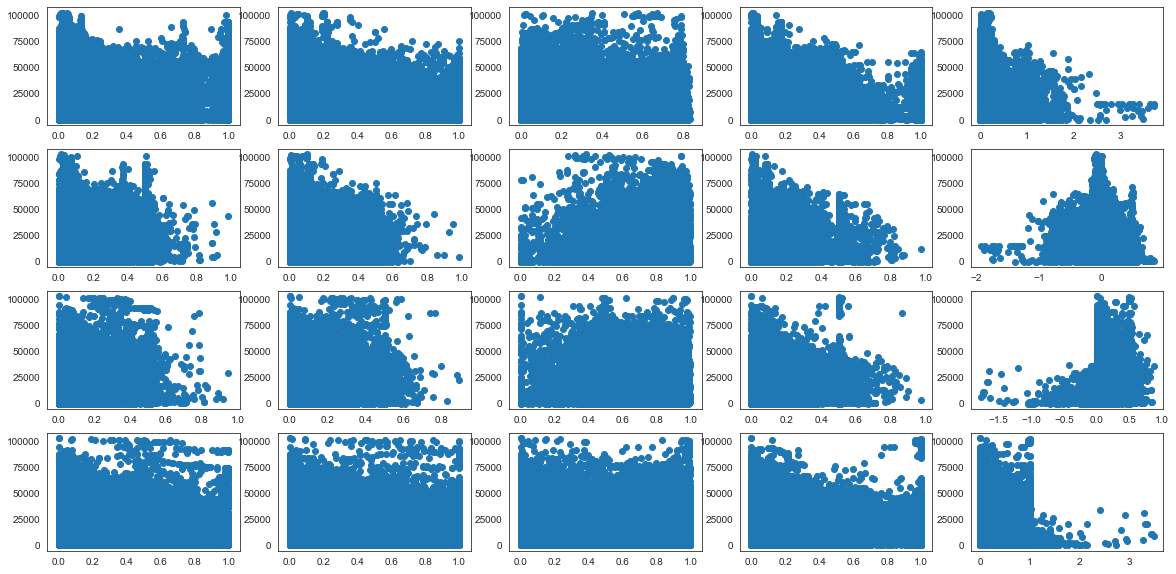

In [290]:
plt.figure(figsize=(20,10))
for i, c in enumerate(close_trainx.columns):
    plt.subplot(4,5,i+1)
    plt.scatter(OLS_df[c], OLS_df.channel_age);

In [302]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(close_trainx, close_trainy)
print('test score is: ',reg.score(close_testx, close_testy))
reg.coef_

test score is:  0.1823877417223705


array([  5452.37024162,    909.20869371,   -372.56239584,  -9236.92198554,
        -8647.29974468,  -8775.61686882,   2709.26771009,  29936.38125409,
       -11620.31239148, -21283.40505813,  64478.32828743,  28292.21339295,
       -25399.13201983, -41412.77898381,  27214.65214175, -35816.42825188,
         2987.05068744,  -1689.32111689,  10749.18387654,   3130.54917942])

In [299]:
formula2 = "channel_age ~  channel_diff_close + bet_diff_close + closeness_diff_close \
+ capacity_diff_close + growth_diff_close + channel_avg_close + bet_avg_close+ closeness_avg_close \
+ capacity_avg_close + growth_avg_close + channel_avg_open + bet_avg_open + closeness_avg_open \
+ capacity_avg_open +  growth_avg_open + channel_diff_open +  bet_diff_open +  closeness_diff_open + \
        capacity_diff_open +  growth_diff_open "
ols2 = smf.ols(formula2, data= OLS_df, missing='drop').fit()
print(ols2.summary())

                            OLS Regression Results                            
Dep. Variable:            channel_age   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     434.9
Date:                Fri, 08 May 2020   Prob (F-statistic):               0.00
Time:                        15:43:25   Log-Likelihood:            -4.2310e+05
No. Observations:               38344   AIC:                         8.462e+05
Df Residuals:                   38323   BIC:                         8.464e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             1.391e+04 

In [278]:
formula1 = "channel_age ~ channel_diff_close"
ols1 = smf.ols(formula1, data= OLS_df, missing='drop').fit()
print(ols1.summary())

                            OLS Regression Results                            
Dep. Variable:            channel_age   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     58.67
Date:                Fri, 08 May 2020   Prob (F-statistic):           1.91e-14
Time:                        15:20:10   Log-Likelihood:            -4.2699e+05
No. Observations:               38344   AIC:                         8.540e+05
Df Residuals:                   38342   BIC:                         8.540e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           1.773e+04    116

In [279]:
formula3 = "channel_age ~ channel_avg_close"
ols3 = smf.ols(formula3, data= OLS_df, missing='drop').fit()
print(ols3.summary())

                            OLS Regression Results                            
Dep. Variable:            channel_age   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     156.6
Date:                Fri, 08 May 2020   Prob (F-statistic):           7.50e-36
Time:                        15:20:31   Log-Likelihood:            -4.2694e+05
No. Observations:               38344   AIC:                         8.539e+05
Df Residuals:                   38342   BIC:                         8.539e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           1.72e+04    124.08

In [280]:
formula4 = "channel_age ~ channel_avg_close + channel_diff_close + growth_diff_close + growth_avg_close + capacity_diff_close + capacity_avg_close "
ols4 = smf.ols(formula4, data= OLS_df, missing='drop').fit()
print(ols4.summary())

                            OLS Regression Results                            
Dep. Variable:            channel_age   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     377.6
Date:                Fri, 08 May 2020   Prob (F-statistic):               0.00
Time:                        15:20:54   Log-Likelihood:            -4.2592e+05
No. Observations:               38344   AIC:                         8.519e+05
Df Residuals:                   38337   BIC:                         8.519e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             1.82e+04    

#### Regression using TPOT for channel_age

In [193]:
from tpot import TPOTRegressor

tpot = TPOTRegressor(generations=5, population_size=20, verbosity=1, scoring='r2')  # generations for optimization, pop size is models
tpot.fit(close_trainx, close_trainy.ravel())
print(tpot.score(close_testx, close_testy.ravel()))
# tpot.export('tpot_heart_pipeline.py')
# Can try again on a smaller sample of data with tqdm



TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.
Best pipeline: RandomForestRegressor(input_matrix, bootstrap=True, max_features=0.7500000000000001, min_samples_leaf=4, min_samples_split=5, n_estimators=100)
0.5347526073749463


In [195]:
tpot_best = tpot.fitted_pipeline_.steps

tpot_best[-1][1].feature_importances_

array([0.11342011, 0.06777757, 0.06505289, 0.15726155, 0.10202487,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.1037416 , 0.09382923, 0.06651351, 0.14031946, 0.09005921])

In [196]:
print(tpot_best[0][1])
tpot_best[0][1].get_feature_names()

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.7500000000000001,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)


AttributeError: 'RandomForestRegressor' object has no attribute 'get_feature_names'

In [ ]:
features = x.columns
# features_plot = features
importances = DT2.feature_importances_
idx = np.argsort(importances)
plt.title("Feature importance")
plt.barh(range(len(idx)), importances[idx])
plt.yticks(range(len(idx)), [features[i] for i in idx])
plt.ylabel("Feature")
plt.show()

### OLS for community impact (efficiency)

**Robustness vs. Efficiency**

In [228]:
snapshot_mes_df.head()

,block,avg_short_path,robustness_eff_loss_1.0,efficiency
1,509496.0,1.992095,0.008624,0.501984
2,511852.0,2.446970,0.054267,0.408669
3,513758.0,2.491979,0.056636,0.401288
4,514060.0,2.584874,0.062203,0.386866
5,514345.0,2.584874,0.062203,0.386866


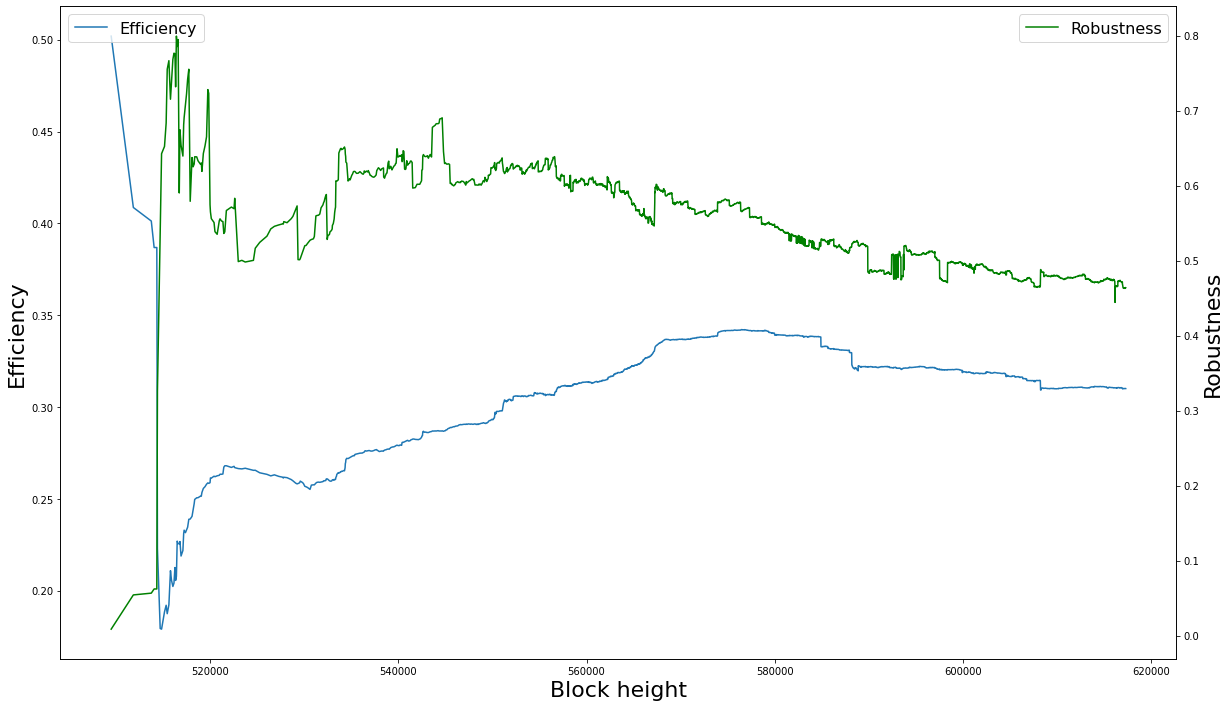

In [537]:
## Plotting robustness vs. efficiency over time


fig,ax1=plt.subplots(figsize=(20,12))

# Efficiency
ax1.plot(snapshot_mes_df['block'], snapshot_mes_df['efficiency'])
ax1.legend(['Efficiency'], loc='upper left',prop={'size': 16})
ax1.set_ylabel('Efficiency',size=22)
ax1.set_xlabel('Block height',size=22)

# Robustness
ax2=ax1.twinx()
ax2.plot(snapshot_mes_df['block'], snapshot_mes_df['robustness_eff_loss_1.0'],color='green')
ax2.set_ylabel('Robustness',size=22)
ax2.legend(['Robustness'], loc='upper right',prop={'size': 16})

In [574]:
len(snapshot_mes_df)

3652

**FUNCTION: Extract number of clusters per block**

In [265]:
def extract_channel_types(channel_df,block_label,block_0,block_1,cluster_label_list):
    
    # Initialize columns list and data to be returned
    
    columns=[]
    data=[]
    
    for cluster_label in cluster_label_list:
        
        
        # Get clusters for a cluster label
        clusters=channel_df[cluster_label].unique()
        
        # Loop over cluster values
        for cluster in clusters:
            
             # Count rows that match a cluster value for a given cluster label
            cluster_i_size=channel_df[(channel_df[cluster_label]==cluster) & (channel_df[block_label]>block_0) & (channel_df[block_label]<=block_1)][cluster_label].count()
            col_label=block_label+'_'+cluster_label+'_'+str(cluster)
            
            # Append to data and column lists
            columns.append(col_label)
            data.append(cluster_i_size)
            
    return (columns,data)
            

**TEST: Cluster number extraction**

In [538]:
clusters_accg_3=clusters_centroids[1][0]

In [539]:
clusters_accg_3.head(10)

,age_avg_open,channel_avg_open,capacity_avg_open,growth_avg_open,age_diff_open,channel_diff_open,capacity_diff_open,growth_diff_open,cluster_label
0,0.349434,0.101950,0.055807,0.330545,0.625429,0.141844,0.100407,0.661589,1
10,0.288184,0.117465,0.029856,0.002084,0.569681,0.220745,0.059594,0.003272,0
11,0.377358,0.065603,0.042583,-0.002973,0.754697,0.127660,0.085104,0.006414,0
12,0.190398,0.007092,0.002569,0.000460,0.380795,0.014184,0.005139,0.000920,0
13,0.448345,0.368351,0.500008,0.112292,0.896226,0.734929,0.999984,0.224337,2
14,0.361238,0.085993,0.219095,0.500121,0.512681,0.152482,0.434985,0.999758,1
15,0.375943,0.016844,0.004095,-0.000120,0.751886,0.031915,0.008159,0.000476,0
16,0.298543,0.079344,0.014293,-0.081446,0.597086,0.158688,0.028585,0.162891,0
17,0.371477,0.016844,0.008332,0.000344,0.742955,0.033688,0.016664,0.000688,0
18,0.247967,0.010638,0.003797,-0.000034,0.494953,0.005319,0.007463,0.001072,0


In [546]:
#clusters_accg_3[clusters_accg_3['cluster_label']==0].sort_values(by=['channel_avg_open'],ascending=False).iloc[200:300]
len(clusters_accg_3[clusters_accg_3['cluster_label']==0])

47846

In [239]:
clusters_accg_3['cluster_label'].count()

72454

In [248]:
blocks_df=full_decisions_df[['open_block','close_block']]

In [273]:
clusters_accg_3=clusters_accg_3.join(blocks_df,how='left')

In [274]:
clusters_accg_3.head()

,age_avg_open,channel_avg_open,capacity_avg_open,growth_avg_open,age_diff_open,channel_diff_open,capacity_diff_open,growth_diff_open,cluster_label,open_block,close_block
0,0.349434,0.101950,0.055807,0.330545,0.625429,0.141844,0.100407,0.661589,1,617297,NaN
10,0.288184,0.117465,0.029856,0.002084,0.569681,0.220745,0.059594,0.003272,0,617290,NaN
11,0.377358,0.065603,0.042583,-0.002973,0.754697,0.127660,0.085104,0.006414,0,617289,NaN
12,0.190398,0.007092,0.002569,0.000460,0.380795,0.014184,0.005139,0.000920,0,617289,NaN
13,0.448345,0.368351,0.500008,0.112292,0.896226,0.734929,0.999984,0.224337,2,617288,NaN


In [266]:
# Test extract_channel_types function

# Select testing index and blocks
test_ix=10000
block_0=blocks[test_ix]
block_1=blocks[test_ix+1]

# Select block column and cluster column list
block_label='open_block'
cluster_label_list=['cluster_label']

# Run function and print output
test_types=extract_channel_types(clusters_accg_3,block_label,block_0,block_1,cluster_label_list)
print('Test types: {}'.format(test_types))



Test types: (['open_block_cluster_label_1', 'open_block_cluster_label_0', 'open_block_cluster_label_2'], [0, 4, 0])


**SCRIPT: Add cluster count for open and close blocks**

In [284]:

# Get list of blocks in snapshot_blocks DF
snapshot_blocks=snapshot_mes_df['block'].tolist()

#print(snapshot_blocks[0])

# Select label list
cluster_label_list=['cluster_label']

# Initialize data lists
cluster_counts=[]


# Loop through blocks 
with tqdm(total=len(snapshot_blocks)-1) as pbar:
    for i in range(1,len(snapshot_blocks)):

        block_0=snapshot_blocks[i-1]
        block_1=snapshot_blocks[i]

        # Run it for opens
        block_label='open_block'
        type_counts_opens=extract_channel_types(clusters_accg_3,block_label,block_0,block_1,cluster_label_list)
        open_column_labels=type_counts_opens[0]
        cluster_counts_opens=type_counts_opens[1]



        # Run it for closes
        block_label='close_block'
        type_counts_closes=extract_channel_types(clusters_accg_3,block_label,block_0,block_1,cluster_label_list)
        close_column_labels=type_counts_closes[0]
        cluster_counts_closes=type_counts_closes[1]


        # Create unified column list (This is redundantly calculated every loop)
        columns_list=['block']+open_column_labels+close_column_labels

        # Create row and appenda to cluster counts list
        cluster_counts_i=[block_1]+cluster_counts_opens+cluster_counts_closes
        cluster_counts.append(cluster_counts_i)
        
        # Update progress bar
        pbar.update(1)
  

# Create DataFrame with results
cluster_counts_df=pd.DataFrame(data=cluster_counts,columns=columns_list)



In [285]:
cluster_counts_df.head()

,block,open_block_cluster_label_1,open_block_cluster_label_0,open_block_cluster_label_2,close_block_cluster_label_1,close_block_cluster_label_0,close_block_cluster_label_2
0,511852.0,5,5,0,0,0,0
1,513758.0,0,11,0,0,0,0
2,514060.0,0,10,0,0,0,0
3,514345.0,0,10,0,0,0,0
4,514412.0,2,10,0,0,0,0


In [308]:
# Join counts into main dataframe 
snapshot_mes_df_reg=pd.merge(snapshot_mes_df,cluster_counts_df,how='left',left_on=['block'],right_on=['block'])
snapshot_mes_df_reg=snapshot_mes_df_reg.dropna()
snapshot_mes_df_reg.rename(columns={'robustness_eff_loss_1.0':'robustness'},inplace=True)
diff_df=snapshot_mes_df_reg.diff()[['robustness','efficiency']].rename(columns={'robustness':'robustness_dif','efficiency':'efficiency_dif'})
snapshot_mes_df_reg=snapshot_mes_df_reg.merge(diff_df,how='inner',left_index=True,right_index=True)
snapshot_mes_df_reg.head()

,block,avg_short_path,robustness,efficiency,open_block_cluster_label_1,open_block_cluster_label_0,open_block_cluster_label_2,close_block_cluster_label_1,close_block_cluster_label_0,close_block_cluster_label_2,robustness_dif,efficiency_dif
1,511852.0,2.446970,0.054267,0.408669,5.0,5.0,0.0,0.0,0.0,0.0,NaN,NaN
2,513758.0,2.491979,0.056636,0.401288,0.0,11.0,0.0,0.0,0.0,0.0,0.002368,-0.007381
3,514060.0,2.584874,0.062203,0.386866,0.0,10.0,0.0,0.0,0.0,0.0,0.005567,-0.014421
4,514345.0,2.584874,0.062203,0.386866,0.0,10.0,0.0,0.0,0.0,0.0,0.000000,0.000000
5,514412.0,4.485714,0.326737,0.222930,2.0,10.0,0.0,0.0,0.0,0.0,0.264534,-0.163936


**REGRESSION: Channel opens and closes by cluster type vs. Efficiency**

In [558]:
formula1 = "efficiency_dif ~ open_block_cluster_label_0+open_block_cluster_label_1+open_block_cluster_label_2+close_block_cluster_label_0+close_block_cluster_label_1+close_block_cluster_label_2"
ols1 = smf.ols(formula1, data= snapshot_mes_df_reg, missing='drop').fit()
print(ols1.summary())

                            OLS Regression Results                            
Dep. Variable:         efficiency_dif   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.495
Date:                Tue, 12 May 2020   Prob (F-statistic):              0.175
Time:                        07:02:06   Log-Likelihood:                 16163.
No. Observations:                3650   AIC:                        -3.231e+04
Df Residuals:                    3643   BIC:                        -3.227e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

**Probability of close**

In [577]:
clusters_centroids[1][0]

72454

In [578]:
full_clusters=full_decisions_df.join(clusters_centroids[1][0])

In [579]:
full_clusters.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'short_channel_id', 'open_block',
       'open_transaction', 'address', 'close_block', 'close_transaction',
       'node0', 'node1', 'satoshis', 'last_seen', 'open_time', 'open_fee',
       'close_time', 'close_fee', 'last_update', 'close_type',
       'close_htlc_count', 'close_balance_a', 'close_balance_b', 'dec_id',
       'node0_id', 'node1_id', 'node_pair', 'age_n0_open_norm_rank',
       'age_n1_open_norm_rank', 'age_n0_close_norm_rank',
       'age_n1_close_norm_rank', 'capacity_n0_open_norm_rank',
       'capacity_n1_open_norm_rank', 'capacity_n0_close_norm_rank',
       'capacity_n1_close_norm_rank', 'capacity_growth_n0_open_norm_rank',
       'capacity_growth_n1_open_norm_rank',
       'capacity_growth_n0_close_norm_rank',
       'capacity_growth_n1_close_norm_rank', 'channels_n0_open_norm_rank',
       'channels_n1_open_norm_rank', 'closeness_approx_rank_n0_open_norm_rank',
       'closeness_approx_rank_n1_open_norm_rank',
       'closene

In [591]:
full_clusters['is_open']=np.where(full_clusters['close_block'].isna(),1, 0)

In [598]:
def duration(c):

    if c['is_open'] == 1:
        return (617300-c['open_block'])
    else:
        return c['close_block']-c['open_block']


In [609]:
full_clusters['duration']= full_clusters.apply(duration, axis=1)
full_clusters['duration']= full_clusters.apply(duration, axis=1)/full_clusters['duration'].max()

In [610]:
full_clusters[full_clusters['is_open']==0][['duration','open_block','close_block']].head()

,duration,open_block,close_block
278,0.001145,617118,617245.0
347,0.000974,617078,617186.0
348,0.000974,617078,617186.0
349,0.000974,617078,617186.0
350,0.000983,617078,617187.0


In [600]:
#prob_reg_df=full_clusters[['cluster_label','duration','is_open']]

In [611]:
formula1 = "is_open ~ C(cluster_label)+duration-1"
logit = smf.logit(formula1, data= full_clusters, missing='drop').fit()
print(logit.summary())

Optimization terminated successfully.
         Current function value: 0.605004
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                is_open   No. Observations:                72454
Model:                          Logit   Df Residuals:                    72450
Method:                           MLE   Df Model:                            3
Date:                Sat, 16 May 2020   Pseudo R-squ.:                  0.1250
Time:                        23:53:19   Log-Likelihood:                -43835.
converged:                       True   LL-Null:                       -50096.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
C(cluster_label)[0.0]    -1.1886      0.015    -81.451      0.000      -1.217      -1.

[Text(0, 0, 'SS Opens'),
 Text(0, 0, 'SM Opens'),
 Text(0, 0, 'SL Opens'),
 Text(0, 0, 'SS Closes'),
 Text(0, 0, 'SM Closes'),
 Text(0, 0, 'SL Closes')]

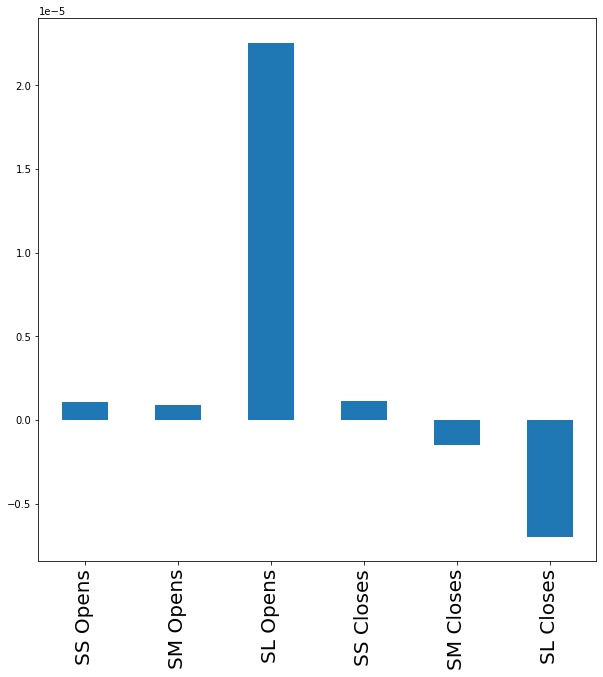

In [571]:
efficiency_params=ols1.params.iloc[1:]
plt.figure(figsize=(10,10))
ax=efficiency_params.plot.bar()
ax.set_xticklabels(['SS Opens','SM Opens','SL Opens','SS Closes','SM Closes','SL Closes'],rotation=90,size=20)

**REGRESSION: Channel opens and closes by cluster type vs. Robustness**

In [573]:
formula1 = "robustness_dif ~ open_block_cluster_label_0+open_block_cluster_label_1+open_block_cluster_label_2+close_block_cluster_label_0+close_block_cluster_label_1+close_block_cluster_label_2"
ols2 = smf.ols(formula1, data= snapshot_mes_df_reg, missing='drop').fit()
print(ols2.summary())

                            OLS Regression Results                            
Dep. Variable:         robustness_dif   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     3.985
Date:                Tue, 12 May 2020   Prob (F-statistic):           0.000558
Time:                        07:54:17   Log-Likelihood:                 11955.
No. Observations:                3650   AIC:                        -2.390e+04
Df Residuals:                    3643   BIC:                        -2.385e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

[Text(0, 0, 'SS Opens'),
 Text(0, 0, 'SM Opens'),
 Text(0, 0, 'SL Opens'),
 Text(0, 0, 'SS Closes'),
 Text(0, 0, 'SM Closes'),
 Text(0, 0, 'SL Closes')]

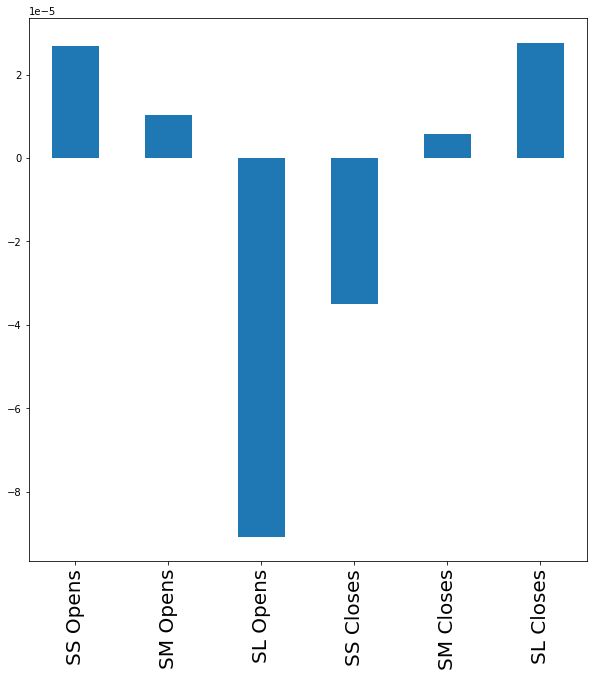

In [572]:
efficiency_params=ols2.params.iloc[1:]
plt.figure(figsize=(10,10))
ax=efficiency_params.plot.bar()
ax.set_xticklabels(['SS Opens','SM Opens','SL Opens','SS Closes','SM Closes','SL Closes'],rotation=90,size=20)

## Preferential Attachment estimations

In [317]:
# Distributions of Decisions per small nodes

node_feature_df.head()

,age,block,capacity_growth,capacity_n,channels,closeness,current_betweeness,decision_type,node
0,0.036720,617297.0,0.661339,0.106011,0.172872,0.983718,0.084238,1.0,5161.0
10,0.003344,617290.0,0.000448,0.000059,0.007092,0.705347,0.002170,1.0,994.0
11,0.000009,617289.0,0.000234,0.000031,0.001773,0.241699,0.000222,1.0,1260.0
12,0.380795,617289.0,0.000920,0.005139,0.014184,0.894494,0.003224,1.0,842.0
13,0.000232,617288.0,0.000123,0.000016,0.000887,0.583382,0.000000,1.0,2246.0


In [350]:
len(node_feature_df[(node_feature_df['channels']<0.2) & (node_feature_df['decision_type']==1)])

108947

In [351]:
block_opencount_df=node_feature_df[node_feature_df['decision_type']==1].groupby(['block']).count()[['age']]
block_opencount_small_df=node_feature_df[(node_feature_df['decision_type']==1) & (node_feature_df['channels']<0.2)].groupby(['block']).count()[['age']]

In [352]:
len(block_opencount_small_df)

30390

In [335]:
len(block_opencount_small_df[block_opencount_small_df['age']<10])

1324

In [ ]:
observed

Text(0.5, 1.0, 'distribution of channel age')

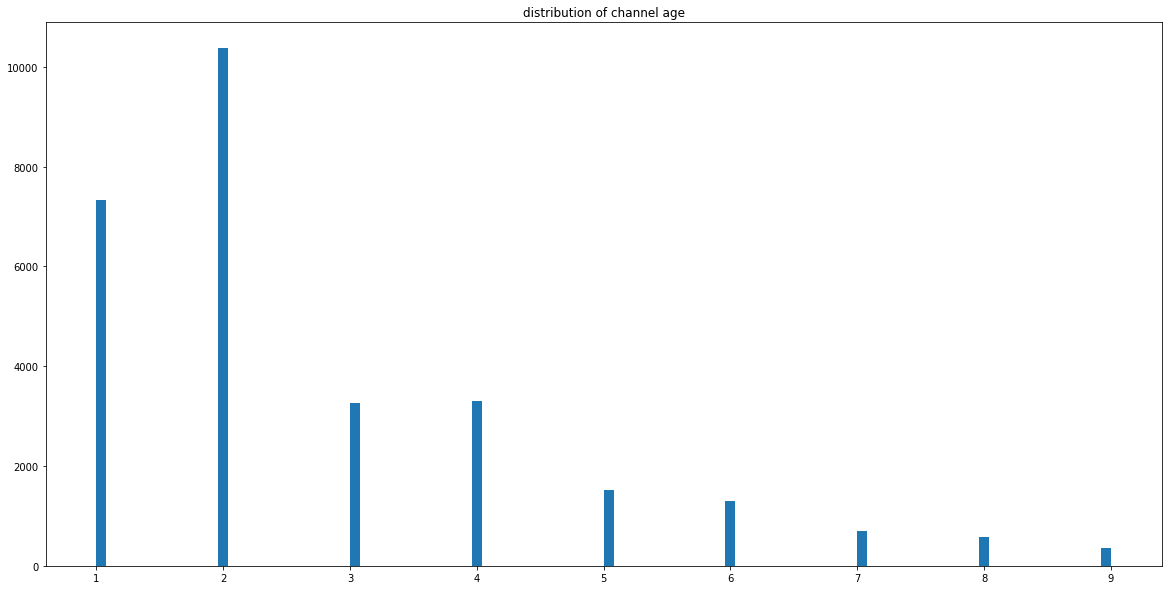

In [337]:
plt.figure(figsize=(20,10))
plt.hist(block_opencount_small_df[block_opencount_small_df['age']<10]['age'],bins=100)
plt.title('distribution of channel age')

In [547]:
observed_small=Decimal(len(full_decisions_df[(full_decisions_df['channels_n0_open_norm_rank']<0.3) & (full_decisions_df['channels_n1_open_norm_rank']<0.3)]))
print(observed_small)

51356


In [554]:
# Number of decisions involving small nodes
small_decisions=Decimal(len(full_decisions_df[(full_decisions_df['channels_n0_open_norm_rank']<0.076197) | (full_decisions_df['channels_n1_open_norm_rank']<0.076197)]))
#small_decisions=47846 From small
print(small_decisions)

67426


In [489]:
all_decisions=Decimal(len(full_decisions_df))
print(all_decisions)

72476


In [484]:
prob=Decimal(0.3)
potential_combinations=nCr(all_decisions,small_decisions)*pow(prob,small_decisions)*pow(1-prob,(all_decisions-small_decisions))
print(potential_combinations)

0.004878043424817356569990845116


In [557]:
prob=Decimal(0.076197)
start_prob=0
min_range=4900
with tqdm(total=len(range(min_range,int(small_decisions)))) as pbar:
    for i in range(min_range,int(small_decisions)):
        i=Decimal(i)
        prob_i=nCr(small_decisions,i)*pow(prob,i)*pow(1-prob,(small_decisions-i))
        start_prob+=prob_i
        pbar.update(1)
    
print('Probability of getting more than {} connections: {}'.format(min_range,start_prob))


Probability of getting more than 4900 connections: 0.9997655157306241884475080903


In [391]:
Decimal(pow(prob,small_decisions)*pow(1-prob,all_decisions-small_decisions))

Decimal('0')

In [433]:
pow(prob,(all_decisions-small_decisions))

Decimal('3.110051738086875055138254690E-37')

In [434]:
pow(1-prob,small_decisions)

Decimal('1.000000000056942894845427621E-128224')

In [385]:
int(Decimal(pow(small_decisions, prob)*pow(all_decisions, 1-prob)))

72475

In [386]:
pow(small_decisions, prob)

1.0000111407927676

In [355]:
full_decisions_df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'short_channel_id', 'open_block',
       'open_transaction', 'address', 'close_block', 'close_transaction',
       'node0', 'node1', 'satoshis', 'last_seen', 'open_time', 'open_fee',
       'close_time', 'close_fee', 'last_update', 'close_type',
       'close_htlc_count', 'close_balance_a', 'close_balance_b', 'dec_id',
       'node0_id', 'node1_id', 'node_pair', 'age_n0_open_norm_rank',
       'age_n1_open_norm_rank', 'age_n0_close_norm_rank',
       'age_n1_close_norm_rank', 'capacity_n0_open_norm_rank',
       'capacity_n1_open_norm_rank', 'capacity_n0_close_norm_rank',
       'capacity_n1_close_norm_rank', 'capacity_growth_n0_open_norm_rank',
       'capacity_growth_n1_open_norm_rank',
       'capacity_growth_n0_close_norm_rank',
       'capacity_growth_n1_close_norm_rank', 'channels_n0_open_norm_rank',
       'channels_n1_open_norm_rank', 'closeness_approx_rank_n0_open_norm_rank',
       'closeness_approx_rank_n1_open_norm_rank',
       'closene

In [376]:


from decimal import Decimal
def fact(n):
    d = Decimal(n)
    return (Decimal(2 * math.pi) * d).sqrt() * (d / Decimal(math.e)) ** d

def nCr(n,r):
    f = math.factorial
    return fact(n) / fact(r) / fact(n-r)